Report

The main objective of this project was to explore how nondeterministic models  (in my case Bayesian Neural Networks)can handle uncertainty in data. My work focused on time series forecasting, with a brief exploration of anomaly detection (as shown in the last slide of the presentation).

The core goal was to develop a training bot capable of predicting bid and ask prices for time series data and executing stock trades while accounting for  diffrent risk management.

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as  np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import math
import json
from scipy.stats import norm
import optuna


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SEQ_LEN = 4

# Load data

In [ ]:
def pdp_go_up(prev_value, mu, std):
    return 1 - norm.cdf(prev_value, loc=mu, scale=std)


In [ ]:
def bnn_eval_strategy(ts, std, mu, threshold=0.5):
    std_bids = std[:, 0]
    mu_bids = mu[:, 0]

    real_asks = ts[:, 1]
    real_bids = ts[:, 0]

    total_profit = 0
    transactions = []

    for t in range(len(ts) - 1):
        ask_now = real_asks[t]
        bid_next = real_bids[t + 1]
        mu_bid_next = mu_bids[t + 1]
        std_bid_next = std_bids[t + 1]

        pp_up = pdp_go_up(ask_now, mu_bid_next, std_bid_next)

        if pp_up > threshold:
            profit = bid_next - ask_now
            total_profit += profit
            transactions.append((t, ask_now, profit))

    return total_profit, transactions

def lstm_eval_strategy(ts, mu):
    mu_bids = mu[:, 0]
    real_asks = ts[:, 1]
    real_bids = ts[:, 0]

    total_profit = 0
    transactions = []

    for t in range(len(ts) - 1):
        ask_now = real_asks[t]
        bid_next = real_bids[t + 1]
        mu_bid_next = mu_bids[t + 1]

        if mu_bid_next > ask_now:
            profit = bid_next - ask_now
            total_profit += profit
            transactions.append((t, ask_now, profit))

    return total_profit, transactions

def plot_buy_points_with_profits(ts, transactions, total_profit):
    real_asks = ts[:, 1]

    plt.figure(figsize=(12, 6))
    plt.plot(real_asks, label="Price ASK", color='blue')

    for t, price, profit in transactions:
        color = 'green' if profit >= 0 else 'red'
        plt.scatter(t, price, color=color, marker='^', s=50, zorder=5)

    plt.title("Transations")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend(["Price - ASK"])

    plt.text(0.01, 0.95, f"Total profit: {total_profit:.2f}", transform=plt.gca().transAxes,
             fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7))

    plt.show()


(4510, 2)


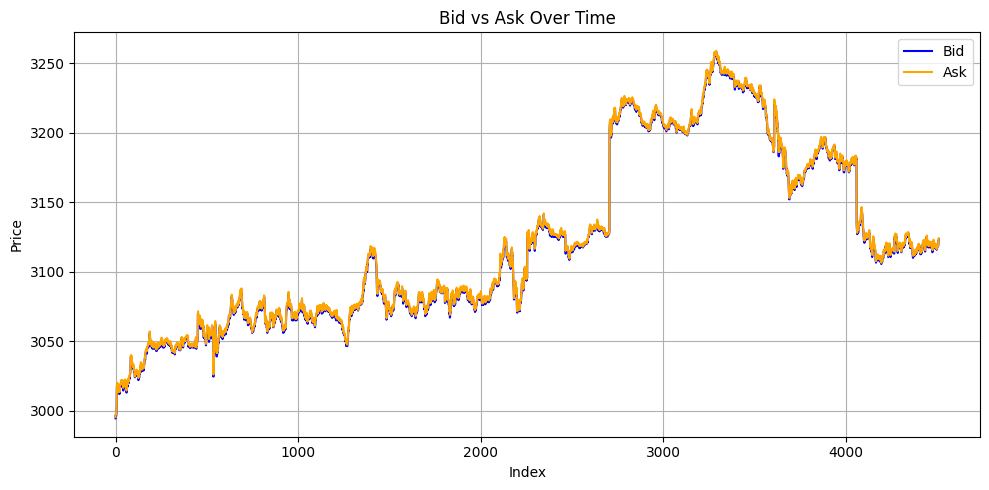

In [ ]:
df = pd.read_csv("/content/bid_ask.csv")
df = df[["bid", "ask"]]
print(df.shape)

plt.figure(figsize=(10, 5))
plt.plot(df["bid"], label="Bid", color="blue")
plt.plot(df["ask"], label="Ask", color="orange")
plt.title("Bid vs Ask Over Time")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Data manipulation

In [ ]:
class Sampler():
    def __init__(self, ts, seq_len=SEQ_LEN, target_len=1, features=2):
        self.seq_len = seq_len
        self.target_len = target_len
        self.window_len = seq_len + target_len
        self.ts = ts
        self.features = features

    def create_sequences(self):
        X, y = [], []
        for i in range(len(self.ts) - self.window_len + 1):
            window = self.ts[i:i+self.seq_len]
            target = self.ts[i+self.seq_len:i+self.seq_len+self.target_len]
            X.append(window)
            y.append(target)

        X = np.array(X)
        y = np.array(y)
        return X, y

In [ ]:
def generate_results_nondeterministic(ts, model, true_to_predict=False, sample_nr=10, seq_len=SEQ_LEN):
    model.eval()
    mean_predictions = []
    std_predictions = []
    device = next(model.parameters()).device

    ts_len = ts.shape[0]
    seq = ts[0:seq_len].copy()

    for i in range(ts_len - seq_len):
        input_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
        predictions = []

        for _ in range(sample_nr):
            model.train()
            with torch.no_grad():
                output = model(input_tensor).cpu().numpy().squeeze()
            predictions.append(output)

        model.eval()

        mean_pred = np.mean(predictions, axis=0)
        std_pred = np.std(predictions, axis=0)

        mean_predictions.append(mean_pred)
        std_predictions.append(std_pred)

        if true_to_predict:
            seq = ts[i + 1:i + 1 + seq_len]
        else:
            seq = np.vstack([seq[1:], mean_pred])

    return np.array(mean_predictions), np.array(std_predictions), ts[seq_len:]

def generate_results_deterministic(ts, model, true_to_predict=False, seq_len=SEQ_LEN):
    model.eval()
    predictions = []
    device = next(model.parameters()).device

    ts_len = ts.shape[0]
    seq = ts[0:seq_len].copy()

    for i in range(ts_len - seq_len):
        input_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor).cpu().numpy().squeeze()

        predictions.append(output)

        if true_to_predict:
            seq = ts[i + 1:i + 1 + seq_len]
        else:
            seq = np.vstack([seq[1:], output])

    return np.array(predictions), ts[seq_len:]


# Plots

In [ ]:
def plot_distributions(real_values, mean, std, max_points=300):

    print(f"real_values: {real_values.shape}")
    print(f"mean: {mean.shape}")
    print(f"std: {std.shape}")

    min_len = min(len(real_values), len(mean), len(std), max_points)
    real_values = real_values[:min_len]
    mean = mean[:min_len]
    std = std[:min_len]

    x = np.arange(min_len)
    colors = ['blue', 'red']
    labels = ['BID', 'ASK']

    for i in range(mean.shape[1]):
        plt.figure(figsize=(14, 8))
        m = mean[:, i]
        s = std[:, i]
        r = real_values[:, i]

        plt.plot(x, r, label=f'{labels[i]} - real values', color=colors[i], linewidth=2, alpha=0.6)
        plt.plot(x, m, label=f'{labels[i]} - predicted values', color=colors[i], linewidth=2)
        plt.plot(x, std, label=f'{labels[i]} - std', color="grey", linewidth=1)

        plt.title('Predicted values and uncertainty - BID/ASK', fontsize=14)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(14, 8))
    for i in range(mean.shape[1]):
        m = mean[:, i]
        r = real_values[:, i]

        plt.plot(x, r, label=f'{labels[i]} - real values', color=colors[i], linewidth=1, alpha=0.6)
        plt.plot(x, m, label=f'{labels[i]} - predicted values', color=colors[i], linewidth=1, linestyle='--')

    plt.title('Predicted values and uncertainty - BID/ASK', fontsize=14)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_strategy(ts, std, mu):
    profits = []
    near_0_5 = []
    tresholds = [i/100 for i in range(1,101)]

    for treshold in tresholds:
        profit, _ = bnn_eval_strategy(ts, std, mu, treshold)
        profits.append(profit)

    max_idx = np.argmax(profits)
    positive_idxs = np.where(np.array(profits) > 0)[0]

    colors = ['blue'] * len(profits)
    for idx in positive_idxs:
        colors[idx] = 'grey'
    colors[max_idx] = 'red'

    plt.figure(figsize=(20,6))
    plt.bar(range(len(profits)), profits, color=colors)
    plt.title(f'Max profits throw all thesholds: {round(max(profits), 3)} for theshold:{max_idx}')
    plt.figtext(0.5, -0.05, f"Idx with positive results: {positive_idxs}", wrap=True, horizontalalignment='center', fontsize=12)

    plt.xlabel('Threshold')
    plt.ylabel('Profit')
    plt.show()

# Models


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dense_layers=None, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.dense = self.create_dense([hidden_size] + (dense_layers or []))

    def create_dense(self, layers):
        seq = []
        for i in range(len(layers) - 1):
            seq.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                seq.append(nn.Sigmoid())
        return nn.Sequential(*seq) if seq else nn.Identity()

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        output, (h, c) = self.lstm(x)
        last_time_step_hidden = h[-1]
        out = self.dense(last_time_step_hidden)
        return out


In [ ]:
class BLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, samples_n, prior_mu=0.0, prior_log_std=-1.0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.samples_n = samples_n

        self.register_buffer('prior_mu', torch.tensor(prior_mu))
        self.register_buffer('prior_log_std', torch.tensor(prior_log_std))

        self.W_x_mu = nn.Parameter(torch.Tensor(input_size, 4 * hidden_size))
        self.W_h_mu = nn.Parameter(torch.Tensor(hidden_size, 4 * hidden_size))
        self.b_mu = nn.Parameter(torch.Tensor(4 * hidden_size))

        self.W_x_log_std = nn.Parameter(torch.Tensor(input_size, 4 * hidden_size))
        self.W_h_log_std = nn.Parameter(torch.Tensor(hidden_size, 4 * hidden_size))
        self.b_log_std = nn.Parameter(torch.Tensor(4 * hidden_size))

        self.init_parameters()

    def init_parameters(self):
        for param in [self.W_x_mu, self.W_h_mu]:
            nn.init.xavier_uniform_(param)
        nn.init.zeros_(self.b_mu)

        for param in [self.W_x_log_std, self.W_h_log_std]:
            nn.init.constant_(param, -1.0)
        nn.init.constant_(self.b_log_std, -1.0)

    def sample_weight(self, mu, log_std):
        if self.training:
            std = torch.exp(log_std)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x, hx):
        h_prev, c_prev = hx

        W_x = self.sample_weight(self.W_x_mu, self.W_x_log_std)
        W_h = self.sample_weight(self.W_h_mu, self.W_h_log_std)
        b = self.sample_weight(self.b_mu, self.b_log_std)

        gates = torch.matmul(x, W_x) + torch.matmul(h_prev, W_h) + b
        i, f, g, o = gates.chunk(4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        c = f * c_prev + i * g
        h = o * torch.tanh(c)

        return h, c

    def kl_divergence(self):
        def kl_gaussian(mu_q, log_std_q, mu_p, log_std_p):
            var_q = torch.exp(2 * log_std_q)
            var_p = torch.exp(2 * log_std_p)

            kl = 0.5 * torch.sum(
                2 * (log_std_p - log_std_q) +
                (var_q + (mu_q - mu_p)**2) / var_p - 1
            )

            return kl

        total_kl = 0
        for mu, log_std in [(self.W_x_mu, self.W_x_log_std),
                           (self.W_h_mu, self.W_h_log_std),
                           (self.b_mu, self.b_log_std)]:
            total_kl += kl_gaussian(mu, log_std, self.prior_mu, self.prior_log_std)

        return total_kl


class BLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dense_layers=None, num_layers=1,
                 num_samples=5, prior_mu=0.0, prior_log_std=-1.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cells = nn.ModuleList()
        self.cells.append(BLSTMCell(input_size, hidden_size, num_samples, prior_mu, prior_log_std))
        for _ in range(1, num_layers):
            self.cells.append(BLSTMCell(hidden_size, hidden_size, num_samples, prior_mu, prior_log_std))

        self.dense = self.create_dense([hidden_size] + dense_layers)

    def create_dense(self, layers):
        if len(layers) <= 1:
            return nn.Identity()

        seq = []
        for i in range(len(layers) - 1):
            seq.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                seq.append(nn.Sigmoid())
        return nn.Sequential(*seq)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)

        batch_size, seq_len, _ = x.size()

        h = [torch.zeros(batch_size, self.hidden_size, device=x.device)
             for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size, device=x.device)
             for _ in range(self.num_layers)]

        for t in range(seq_len):
            input_t = x[:, t, :]
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.cells[layer](input_t, (h[layer], c[layer]))
                input_t = h[layer]

        final_output = self.dense(h[-1])
        return final_output

    def kl_divergence(self):
        return sum(cell.kl_divergence() for cell in self.cells)

# Train

In [ ]:
def train_bnn(model, trainloader, valloader, optimizer, epochs=100,
                  kl_weight_start=0.0, kl_weight_end=0.01, warmup_epochs=100, patience = 25):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        if epoch < warmup_epochs:
            kl_weight = kl_weight_start + (kl_weight_end - kl_weight_start) * (epoch / warmup_epochs)
        else:
            kl_weight = kl_weight_end

        model.train()
        train_loss = 0.0
        train_mse = 0.0
        train_kl = 0.0

        for x_batch, y_batch in trainloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).squeeze(1)

            optimizer.zero_grad()
            output = model(x_batch)

            mse_loss = F.mse_loss(output, y_batch)
            kl_loss = model.kl_divergence()

            kl_loss = kl_loss / sum(p.numel() for p in model.parameters())

            total_loss = mse_loss + kl_weight * kl_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += total_loss.item()
            train_mse += mse_loss.item()
            train_kl += kl_loss.item()

        avg_train_loss = train_loss / len(trainloader)
        avg_train_mse = train_mse / len(trainloader)
        avg_train_kl = train_kl / len(trainloader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in valloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).squeeze(1)
                output = model(x_batch)

                loss = F.mse_loss(output, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valloader)

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train - Total: {avg_train_loss:.6f}, MSE: {avg_train_mse:.6f}, KL: {avg_train_kl:.6f}")
            print(f"  Val MSE: {avg_val_loss:.6f}, KL weight: {kl_weight:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return model, avg_val_loss


In [ ]:
sampler = Sampler(df, features = 2)
X, y  = sampler.create_sequences()

In [ ]:
x_size = len(df)
train_limit = 0.7
val_limit = 0.15

train_end = int(x_size * train_limit)
val_end = int(x_size * (train_limit + val_limit))

train_ts = df[:train_end]
val_ts = df[train_end:val_end]

scaler = MinMaxScaler()
train_ts_scaled = scaler.fit_transform(train_ts)
val_ts_scaled = scaler.transform(val_ts)

train_sampler = Sampler(train_ts_scaled, features=2)
val_sampler = Sampler(val_ts_scaled, features=2)

X_train, y_train = train_sampler.create_sequences()
X_val, y_val = val_sampler.create_sequences()

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=16)


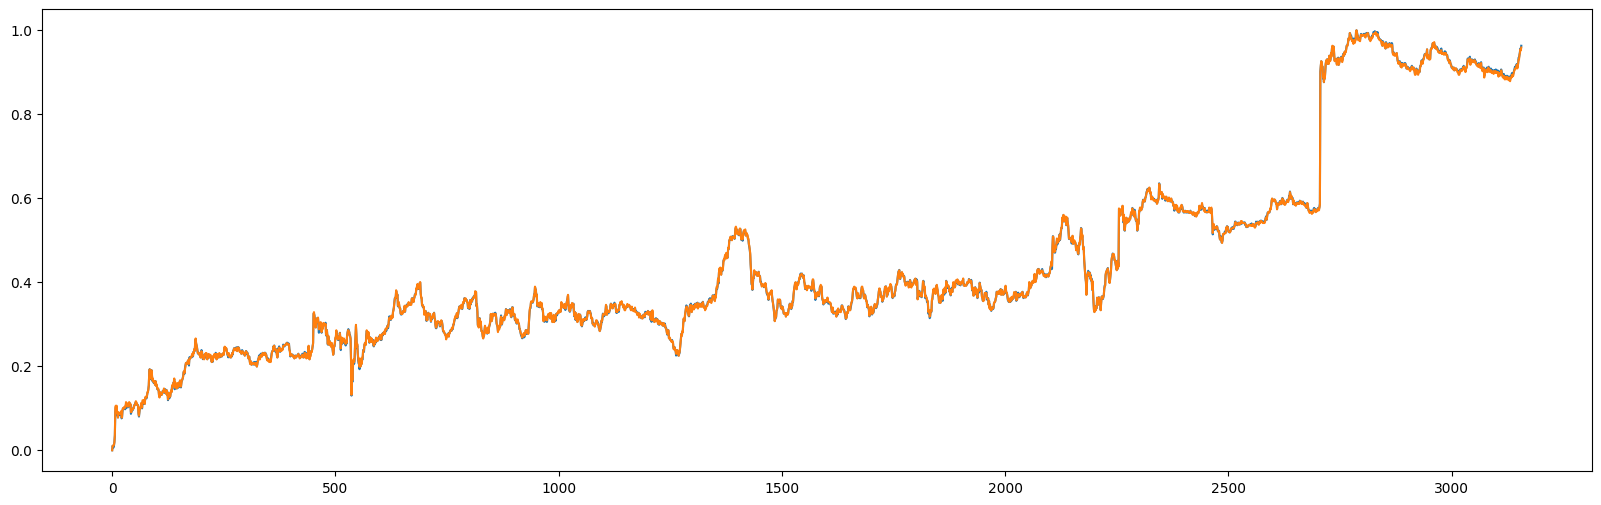

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(np.arange(len(train_ts_scaled)), train_ts_scaled)

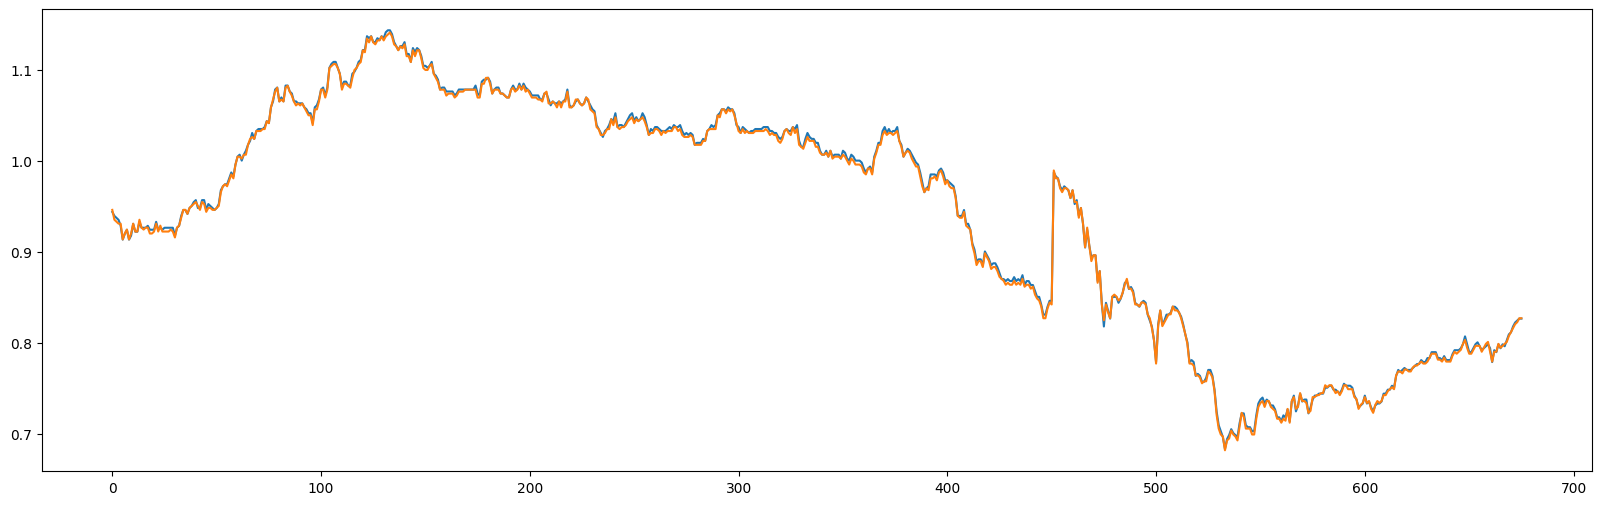

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.arange(len(val_ts_scaled)), val_ts_scaled)

In [ ]:
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 15, 30)
    prior_mu = trial.suggest_float('prior_mu', -1.0, 1.0)
    prior_log_std = trial.suggest_float('prior_log_std', -1, 0.2)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 0.01, 0.05)

    model = BLSTM(
        input_size=2,
        hidden_size=hidden_size,
        dense_layers=[hidden_size, 10, 2],
        num_samples=10,
        num_layers=1,
        prior_mu=prior_mu,
        prior_log_std=prior_log_std
    ).to(device)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    _, avg_val_loss = train_bnn(
        model,
        trainloader,
        valloader,
        optimizer,
        epochs=50,
        kl_weight_end=0.01,
        patience=25
    )


    return avg_val_loss


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

print("Best trial:")
print(study.best_trial)

[I 2025-06-18 20:38:03,159] A new study created in memory with name: no-name-22900a36-f658-463d-9004-f6d9e22ecd6a


Epoch 1/50
  Train - Total: 0.025398, MSE: 0.025398, KL: 0.317956
  Val MSE: 0.015546, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000786, MSE: 0.000562, KL: 0.224530
  Val MSE: 0.011427, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000778, MSE: 0.000566, KL: 0.105998
  Val MSE: 0.004956, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000657, MSE: 0.000433, KL: 0.074396
  Val MSE: 0.005183, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000580, MSE: 0.000342, KL: 0.059396
  Val MSE: 0.004499, KL weight: 0.004000


[I 2025-06-18 20:39:25,354] Trial 0 finished with value: 0.0005153842369379293 and parameters: {'hidden_size': 28, 'prior_mu': -0.25451367892960874, 'prior_log_std': -0.02742539093440477, 'optimizer': 'Adam', 'lr': 0.03772345483784046}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.028906, MSE: 0.028906, KL: 0.358021
  Val MSE: 0.005674, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000716, MSE: 0.000441, KL: 0.274631
  Val MSE: 0.002218, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000663, MSE: 0.000380, KL: 0.141510
  Val MSE: 0.003349, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000648, MSE: 0.000332, KL: 0.105075
  Val MSE: 0.001332, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000683, MSE: 0.000319, KL: 0.091073
  Val MSE: 0.004276, KL weight: 0.004000


[I 2025-06-18 20:40:47,352] Trial 1 finished with value: 0.0032280944853396035 and parameters: {'hidden_size': 23, 'prior_mu': 0.574371702190108, 'prior_log_std': 0.016086569448616306, 'optimizer': 'Adam', 'lr': 0.02824608330003498}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.055863, MSE: 0.055863, KL: 0.274904
  Val MSE: 0.268135, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.053305, MSE: 0.053030, KL: 0.274902
  Val MSE: 0.278444, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.053765, MSE: 0.053215, KL: 0.274898
  Val MSE: 0.267654, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.053934, MSE: 0.053109, KL: 0.274894
  Val MSE: 0.249793, KL weight: 0.003000


[I 2025-06-18 20:41:50,081] Trial 2 finished with value: 0.24567935633517446 and parameters: {'hidden_size': 30, 'prior_mu': -0.3190272060713457, 'prior_log_std': 0.01663797115237453, 'optimizer': 'SGD', 'lr': 0.0419335503775393}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 40
Epoch 1/50
  Train - Total: 0.056680, MSE: 0.056680, KL: 0.191840
  Val MSE: 0.254443, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.053007, MSE: 0.052815, KL: 0.191839
  Val MSE: 0.290194, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.053115, MSE: 0.052731, KL: 0.191835
  Val MSE: 0.266325, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.053392, MSE: 0.052817, KL: 0.191830
  Val MSE: 0.279836, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.053590, MSE: 0.052822, KL: 0.191821
  Val MSE: 0.280565, KL weight: 0.004000


[I 2025-06-18 20:43:04,729] Trial 3 finished with value: 0.27291043085001765 and parameters: {'hidden_size': 18, 'prior_mu': -0.18860826816222964, 'prior_log_std': -0.18641444487605663, 'optimizer': 'SGD', 'lr': 0.02792647195988906}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 48
Epoch 1/50
  Train - Total: 0.022190, MSE: 0.022190, KL: 0.291089
  Val MSE: 0.008695, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000671, MSE: 0.000458, KL: 0.212281
  Val MSE: 0.002292, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000523, MSE: 0.000325, KL: 0.098662
  Val MSE: 0.001531, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000492, MSE: 0.000290, KL: 0.067528
  Val MSE: 0.000778, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000506, MSE: 0.000279, KL: 0.056663
  Val MSE: 0.003817, KL weight: 0.004000


[I 2025-06-18 20:44:22,945] Trial 4 finished with value: 0.0033075434427397945 and parameters: {'hidden_size': 30, 'prior_mu': -0.18661176267596402, 'prior_log_std': 0.009601772736009373, 'optimizer': 'Adam', 'lr': 0.029492756212102296}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.025456, MSE: 0.025456, KL: 0.493649
  Val MSE: 0.006830, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000918, MSE: 0.000601, KL: 0.317614
  Val MSE: 0.007264, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.001072, MSE: 0.000680, KL: 0.196196
  Val MSE: 0.002992, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000996, MSE: 0.000512, KL: 0.161541
  Val MSE: 0.002858, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.001064, MSE: 0.000458, KL: 0.151369
  Val MSE: 0.002840, KL weight: 0.004000


[I 2025-06-18 20:45:28,908] Trial 5 finished with value: 0.004806970689449892 and parameters: {'hidden_size': 15, 'prior_mu': 0.6492932819472541, 'prior_log_std': -0.43958507805721414, 'optimizer': 'Adam', 'lr': 0.04135459718150224}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 42
Epoch 1/50
  Train - Total: 0.023910, MSE: 0.023910, KL: 0.471369
  Val MSE: 0.003549, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000852, MSE: 0.000540, KL: 0.312442
  Val MSE: 0.003906, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000787, MSE: 0.000401, KL: 0.192882
  Val MSE: 0.003517, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.001069, MSE: 0.000588, KL: 0.160538
  Val MSE: 0.006455, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.001182, MSE: 0.000606, KL: 0.143881
  Val MSE: 0.002598, KL weight: 0.004000


[I 2025-06-18 20:46:47,259] Trial 6 finished with value: 0.004912428950947721 and parameters: {'hidden_size': 24, 'prior_mu': 0.4532589386556105, 'prior_log_std': -0.9005404477853806, 'optimizer': 'Adam', 'lr': 0.027394787198754253}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.022362, MSE: 0.022362, KL: 0.663184
  Val MSE: 0.006802, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000580, MSE: 0.000372, KL: 0.207828
  Val MSE: 0.002178, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000589, MSE: 0.000360, KL: 0.114821
  Val MSE: 0.001251, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000640, MSE: 0.000375, KL: 0.088517
  Val MSE: 0.001466, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000692, MSE: 0.000413, KL: 0.069654
  Val MSE: 0.006101, KL weight: 0.004000


[I 2025-06-18 20:48:05,178] Trial 7 finished with value: 0.001874001262963464 and parameters: {'hidden_size': 16, 'prior_mu': -0.8554011864437681, 'prior_log_std': -0.49104097961749016, 'optimizer': 'Adam', 'lr': 0.04300355848641187}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.026869, MSE: 0.026869, KL: 0.157580
  Val MSE: 0.012770, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000777, MSE: 0.000593, KL: 0.184059
  Val MSE: 0.007398, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000654, MSE: 0.000435, KL: 0.109328
  Val MSE: 0.002005, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000746, MSE: 0.000484, KL: 0.087202
  Val MSE: 0.005022, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000605, MSE: 0.000320, KL: 0.071180
  Val MSE: 0.001381, KL weight: 0.004000


[I 2025-06-18 20:49:23,068] Trial 8 finished with value: 0.0029247046699354194 and parameters: {'hidden_size': 28, 'prior_mu': 0.08394908248245314, 'prior_log_std': -0.43019301563390566, 'optimizer': 'Adam', 'lr': 0.020335297550233094}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.023526, MSE: 0.023526, KL: 0.456236
  Val MSE: 0.010790, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000933, MSE: 0.000595, KL: 0.338125
  Val MSE: 0.005400, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000624, MSE: 0.000363, KL: 0.130622
  Val MSE: 0.003279, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000498, MSE: 0.000290, KL: 0.069564
  Val MSE: 0.001378, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000486, MSE: 0.000289, KL: 0.049386
  Val MSE: 0.002372, KL weight: 0.004000


[I 2025-06-18 20:50:41,145] Trial 9 finished with value: 0.0014596606561532272 and parameters: {'hidden_size': 24, 'prior_mu': -0.7189701210342583, 'prior_log_std': -0.5143782266075227, 'optimizer': 'Adam', 'lr': 0.02030362853273649}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.056329, MSE: 0.056329, KL: 0.364602
  Val MSE: 0.281810, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.053379, MSE: 0.053015, KL: 0.364600
  Val MSE: 0.302350, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.053825, MSE: 0.053096, KL: 0.364595
  Val MSE: 0.293307, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.054012, MSE: 0.052918, KL: 0.364587
  Val MSE: 0.276531, KL weight: 0.003000


[I 2025-06-18 20:51:32,843] Trial 10 finished with value: 0.3054537100806123 and parameters: {'hidden_size': 26, 'prior_mu': -0.5455781390026121, 'prior_log_std': 0.1995279133317336, 'optimizer': 'SGD', 'lr': 0.04944649556504553}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 34
Epoch 1/50
  Train - Total: 0.032326, MSE: 0.032326, KL: 0.880137
  Val MSE: 0.011347, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.001252, MSE: 0.000630, KL: 0.622568
  Val MSE: 0.007326, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000821, MSE: 0.000430, KL: 0.195636
  Val MSE: 0.003218, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000584, MSE: 0.000300, KL: 0.094442
  Val MSE: 0.001812, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000621, MSE: 0.000347, KL: 0.068384
  Val MSE: 0.001464, KL weight: 0.004000


[I 2025-06-18 20:52:50,802] Trial 11 finished with value: 0.002316918528906951 and parameters: {'hidden_size': 21, 'prior_mu': -0.9171657399521889, 'prior_log_std': -0.7455842288577194, 'optimizer': 'Adam', 'lr': 0.011681992814555644}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.030833, MSE: 0.030833, KL: 0.320383
  Val MSE: 0.011746, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000693, MSE: 0.000455, KL: 0.238035
  Val MSE: 0.007497, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000577, MSE: 0.000376, KL: 0.100684
  Val MSE: 0.004284, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000446, MSE: 0.000266, KL: 0.059826
  Val MSE: 0.003631, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000416, MSE: 0.000249, KL: 0.041725
  Val MSE: 0.007512, KL weight: 0.004000


[I 2025-06-18 20:54:08,633] Trial 12 finished with value: 0.0010347765455662739 and parameters: {'hidden_size': 26, 'prior_mu': -0.5830229222601913, 'prior_log_std': -0.2147116178711609, 'optimizer': 'Adam', 'lr': 0.019149857739075616}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.016081, MSE: 0.016081, KL: 0.258654
  Val MSE: 0.022966, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000741, MSE: 0.000557, KL: 0.184206
  Val MSE: 0.003997, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000608, MSE: 0.000403, KL: 0.102318
  Val MSE: 0.002564, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000681, MSE: 0.000433, KL: 0.082811
  Val MSE: 0.002521, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000559, MSE: 0.000278, KL: 0.070252
  Val MSE: 0.001469, KL weight: 0.004000


[I 2025-06-18 20:55:26,381] Trial 13 finished with value: 0.0017543384455209541 and parameters: {'hidden_size': 27, 'prior_mu': 0.16302602631049762, 'prior_log_std': -0.18192359329110727, 'optimizer': 'Adam', 'lr': 0.035792864914355314}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.064222, MSE: 0.064222, KL: 0.488375
  Val MSE: 0.249520, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.053865, MSE: 0.053377, KL: 0.488372
  Val MSE: 0.275176, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.053823, MSE: 0.052846, KL: 0.488365
  Val MSE: 0.256230, KL weight: 0.002000


[I 2025-06-18 20:56:08,184] Trial 14 finished with value: 0.26127861174089567 and parameters: {'hidden_size': 26, 'prior_mu': 0.9817030688937396, 'prior_log_std': -0.2154989391401443, 'optimizer': 'SGD', 'lr': 0.015052886979703233}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 28
Epoch 1/50
  Train - Total: 0.020040, MSE: 0.020040, KL: 0.332786
  Val MSE: 0.015476, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000617, MSE: 0.000424, KL: 0.192873
  Val MSE: 0.004977, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000556, MSE: 0.000328, KL: 0.114372
  Val MSE: 0.006458, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000591, MSE: 0.000310, KL: 0.093705
  Val MSE: 0.003283, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000772, MSE: 0.000478, KL: 0.073489
  Val MSE: 0.004498, KL weight: 0.004000


[I 2025-06-18 20:57:25,971] Trial 15 finished with value: 0.0015630544412921327 and parameters: {'hidden_size': 20, 'prior_mu': -0.5031730156687279, 'prior_log_std': -0.28041806095609345, 'optimizer': 'Adam', 'lr': 0.03401606533955115}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.017309, MSE: 0.017309, KL: 0.328806
  Val MSE: 0.014432, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000855, MSE: 0.000575, KL: 0.279690
  Val MSE: 0.004224, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000612, MSE: 0.000390, KL: 0.110907
  Val MSE: 0.005444, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000496, MSE: 0.000307, KL: 0.063198
  Val MSE: 0.002766, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000499, MSE: 0.000302, KL: 0.049164
  Val MSE: 0.000740, KL weight: 0.004000


[I 2025-06-18 20:58:44,011] Trial 16 finished with value: 0.0013209507525884657 and parameters: {'hidden_size': 28, 'prior_mu': -0.5277087631145697, 'prior_log_std': -0.6379919081335395, 'optimizer': 'Adam', 'lr': 0.021142161400862478}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.017915, MSE: 0.017915, KL: 0.364428
  Val MSE: 0.008207, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000896, MSE: 0.000618, KL: 0.278043
  Val MSE: 0.007450, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000881, MSE: 0.000603, KL: 0.138685
  Val MSE: 0.005366, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000619, MSE: 0.000364, KL: 0.085018
  Val MSE: 0.004738, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000487, MSE: 0.000227, KL: 0.064829
  Val MSE: 0.001242, KL weight: 0.004000


[I 2025-06-18 21:00:01,837] Trial 17 finished with value: 0.0009962069877171114 and parameters: {'hidden_size': 25, 'prior_mu': 0.21501347921913005, 'prior_log_std': 0.1984454920196247, 'optimizer': 'Adam', 'lr': 0.035009608410872514}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.071758, MSE: 0.071758, KL: 0.319943
  Val MSE: 0.300629, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.053549, MSE: 0.053229, KL: 0.319943
  Val MSE: 0.278418, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.053814, MSE: 0.053174, KL: 0.319940
  Val MSE: 0.288447, KL weight: 0.002000


[I 2025-06-18 21:00:45,499] Trial 18 finished with value: 0.22020030119234607 and parameters: {'hidden_size': 21, 'prior_mu': 0.21235079667863294, 'prior_log_std': 0.18315632605532883, 'optimizer': 'SGD', 'lr': 0.03609315240257934}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 29
Epoch 1/50
  Train - Total: 0.022132, MSE: 0.022132, KL: 0.391690
  Val MSE: 0.022957, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000807, MSE: 0.000543, KL: 0.264003
  Val MSE: 0.003615, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000486, MSE: 0.000239, KL: 0.123636
  Val MSE: 0.002317, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000546, MSE: 0.000258, KL: 0.096189
  Val MSE: 0.002372, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.001734, MSE: 0.001265, KL: 0.117215
  Val MSE: 0.004815, KL weight: 0.004000


[I 2025-06-18 21:02:03,283] Trial 19 finished with value: 0.0026541875600482206 and parameters: {'hidden_size': 24, 'prior_mu': 0.3400088349554612, 'prior_log_std': 0.09456234872782536, 'optimizer': 'Adam', 'lr': 0.04957052827901855}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 50
Epoch 1/50
  Train - Total: 0.022976, MSE: 0.022976, KL: 0.283691
  Val MSE: 0.014777, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000679, MSE: 0.000501, KL: 0.177577
  Val MSE: 0.007061, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000558, MSE: 0.000381, KL: 0.088437
  Val MSE: 0.001861, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000693, MSE: 0.000509, KL: 0.061316
  Val MSE: 0.002386, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000486, MSE: 0.000295, KL: 0.047737
  Val MSE: 0.001879, KL weight: 0.004000


[I 2025-06-18 21:03:21,691] Trial 20 finished with value: 0.0014852885890702186 and parameters: {'hidden_size': 29, 'prior_mu': -0.06360758434339758, 'prior_log_std': -0.0469371648689938, 'optimizer': 'Adam', 'lr': 0.03267051197292439}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.016028, MSE: 0.016028, KL: 0.274278
  Val MSE: 0.006959, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000520, MSE: 0.000362, KL: 0.157283
  Val MSE: 0.003639, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000634, MSE: 0.000459, KL: 0.087583
  Val MSE: 0.002507, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000495, MSE: 0.000295, KL: 0.066898
  Val MSE: 0.001976, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000476, MSE: 0.000253, KL: 0.055852
  Val MSE: 0.002010, KL weight: 0.004000


[I 2025-06-18 21:04:39,933] Trial 21 finished with value: 0.0014259755402495752 and parameters: {'hidden_size': 26, 'prior_mu': -0.053693471409053894, 'prior_log_std': -0.09438485831344465, 'optimizer': 'Adam', 'lr': 0.03855424748197291}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.016438, MSE: 0.016438, KL: 0.233265
  Val MSE: 0.013207, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000625, MSE: 0.000442, KL: 0.183150
  Val MSE: 0.005442, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000546, MSE: 0.000357, KL: 0.094430
  Val MSE: 0.002025, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000455, MSE: 0.000274, KL: 0.060482
  Val MSE: 0.001923, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000538, MSE: 0.000346, KL: 0.048042
  Val MSE: 0.001223, KL weight: 0.004000


[I 2025-06-18 21:05:58,159] Trial 22 finished with value: 0.0015978879018803127 and parameters: {'hidden_size': 25, 'prior_mu': -0.3760279581280701, 'prior_log_std': -0.33198155582132466, 'optimizer': 'Adam', 'lr': 0.02380393044232993}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.024180, MSE: 0.024180, KL: 0.435519
  Val MSE: 0.015597, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.001126, MSE: 0.000863, KL: 0.263579
  Val MSE: 0.005882, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000570, MSE: 0.000345, KL: 0.112207
  Val MSE: 0.002375, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000611, MSE: 0.000430, KL: 0.060374
  Val MSE: 0.008409, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000627, MSE: 0.000371, KL: 0.064014
  Val MSE: 0.002050, KL weight: 0.004000


[I 2025-06-18 21:07:16,254] Trial 23 finished with value: 0.0014032311977470748 and parameters: {'hidden_size': 28, 'prior_mu': -0.6797789449250918, 'prior_log_std': 0.11605126854739453, 'optimizer': 'Adam', 'lr': 0.045114519085702465}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.016605, MSE: 0.016605, KL: 0.281598
  Val MSE: 0.012983, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000900, MSE: 0.000693, KL: 0.206866
  Val MSE: 0.008930, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000622, MSE: 0.000436, KL: 0.092993
  Val MSE: 0.002374, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000620, MSE: 0.000424, KL: 0.065066
  Val MSE: 0.002717, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000555, MSE: 0.000346, KL: 0.052228
  Val MSE: 0.003424, KL weight: 0.004000


[I 2025-06-18 21:08:34,072] Trial 24 finished with value: 0.001193406137168668 and parameters: {'hidden_size': 27, 'prior_mu': -0.30007893172726574, 'prior_log_std': -0.11183906202512883, 'optimizer': 'Adam', 'lr': 0.03149733031792416}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.014975, MSE: 0.014975, KL: 0.409758
  Val MSE: 0.006653, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000812, MSE: 0.000531, KL: 0.280537
  Val MSE: 0.005631, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000568, MSE: 0.000320, KL: 0.124123
  Val MSE: 0.001906, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000528, MSE: 0.000331, KL: 0.065843
  Val MSE: 0.001675, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000473, MSE: 0.000260, KL: 0.053360
  Val MSE: 0.002997, KL weight: 0.004000


[I 2025-06-18 21:09:51,842] Trial 25 finished with value: 0.0011837778246921343 and parameters: {'hidden_size': 22, 'prior_mu': -0.6854893685503345, 'prior_log_std': 0.09869806816816334, 'optimizer': 'Adam', 'lr': 0.038434752994497404}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.059770, MSE: 0.059770, KL: 0.182670
  Val MSE: 0.275090, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.053319, MSE: 0.053136, KL: 0.182668
  Val MSE: 0.281629, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.053305, MSE: 0.052940, KL: 0.182666
  Val MSE: 0.257218, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.053713, MSE: 0.053165, KL: 0.182662
  Val MSE: 0.268123, KL weight: 0.003000


[I 2025-06-18 21:10:39,717] Trial 26 finished with value: 0.2497939651033708 and parameters: {'hidden_size': 25, 'prior_mu': 0.30871874441048797, 'prior_log_std': -0.29966148471385823, 'optimizer': 'SGD', 'lr': 0.016407782122523036}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 32
Epoch 1/50
  Train - Total: 0.029367, MSE: 0.029367, KL: 0.226786
  Val MSE: 0.009513, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.001155, MSE: 0.000902, KL: 0.253129
  Val MSE: 0.010385, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000840, MSE: 0.000528, KL: 0.155908
  Val MSE: 0.005836, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000727, MSE: 0.000451, KL: 0.092123
  Val MSE: 0.004226, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000714, MSE: 0.000439, KL: 0.068862
  Val MSE: 0.003528, KL weight: 0.004000


[I 2025-06-18 21:11:57,754] Trial 27 finished with value: 0.0025085812190982757 and parameters: {'hidden_size': 29, 'prior_mu': 0.04022408667689481, 'prior_log_std': -0.09563527695009306, 'optimizer': 'Adam', 'lr': 0.010738866156381515}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.016047, MSE: 0.016047, KL: 0.332706
  Val MSE: 0.007095, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000732, MSE: 0.000519, KL: 0.212426
  Val MSE: 0.006585, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000648, MSE: 0.000463, KL: 0.092509
  Val MSE: 0.006846, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000441, MSE: 0.000261, KL: 0.059821
  Val MSE: 0.002406, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000808, MSE: 0.000562, KL: 0.061411
  Val MSE: 0.001519, KL weight: 0.004000


[I 2025-06-18 21:13:10,613] Trial 28 finished with value: 0.0012740420717082522 and parameters: {'hidden_size': 27, 'prior_mu': -0.12453157070536217, 'prior_log_std': 0.08289490611328698, 'optimizer': 'Adam', 'lr': 0.03874896684021802}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 47
Epoch 1/50
  Train - Total: 0.019807, MSE: 0.019807, KL: 0.350886
  Val MSE: 0.016224, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000839, MSE: 0.000557, KL: 0.282387
  Val MSE: 0.005904, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000588, MSE: 0.000305, KL: 0.141403
  Val MSE: 0.001156, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000596, MSE: 0.000318, KL: 0.092580
  Val MSE: 0.001437, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000744, MSE: 0.000429, KL: 0.078688
  Val MSE: 0.001668, KL weight: 0.004000


[I 2025-06-18 21:14:29,101] Trial 29 finished with value: 0.002007146450480269 and parameters: {'hidden_size': 23, 'prior_mu': 0.5394918953689865, 'prior_log_std': 0.0015346095004194205, 'optimizer': 'Adam', 'lr': 0.024918377924747995}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.021466, MSE: 0.021466, KL: 0.536176
  Val MSE: 0.009181, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000875, MSE: 0.000579, KL: 0.296198
  Val MSE: 0.002914, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000772, MSE: 0.000418, KL: 0.177076
  Val MSE: 0.002755, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000770, MSE: 0.000390, KL: 0.126734
  Val MSE: 0.006268, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000907, MSE: 0.000444, KL: 0.115935
  Val MSE: 0.002328, KL weight: 0.004000


[I 2025-06-18 21:15:46,949] Trial 30 finished with value: 0.0023352979604255994 and parameters: {'hidden_size': 23, 'prior_mu': 0.9282901281935875, 'prior_log_std': -0.15208442852888857, 'optimizer': 'Adam', 'lr': 0.03491595071545961}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.020791, MSE: 0.020791, KL: 0.432352
  Val MSE: 0.010395, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000832, MSE: 0.000574, KL: 0.257925
  Val MSE: 0.006915, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000749, MSE: 0.000520, KL: 0.114152
  Val MSE: 0.002642, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000578, MSE: 0.000394, KL: 0.061325
  Val MSE: 0.015747, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000905, MSE: 0.000654, KL: 0.062898
  Val MSE: 0.001215, KL weight: 0.004000


[I 2025-06-18 21:17:05,140] Trial 31 finished with value: 0.004763876615297271 and parameters: {'hidden_size': 22, 'prior_mu': -0.6996156368960633, 'prior_log_std': 0.11455941893044824, 'optimizer': 'Adam', 'lr': 0.03892850012588336}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.014400, MSE: 0.014400, KL: 0.349796
  Val MSE: 0.016836, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000668, MSE: 0.000489, KL: 0.178762
  Val MSE: 0.010046, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000613, MSE: 0.000409, KL: 0.101603
  Val MSE: 0.002783, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000671, MSE: 0.000445, KL: 0.075430
  Val MSE: 0.005494, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000649, MSE: 0.000370, KL: 0.069805
  Val MSE: 0.001755, KL weight: 0.004000


[I 2025-06-18 21:18:22,718] Trial 32 finished with value: 0.0013083735721877367 and parameters: {'hidden_size': 19, 'prior_mu': -0.35433764851389726, 'prior_log_std': 0.034007615963139386, 'optimizer': 'Adam', 'lr': 0.04489127965332182}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.017179, MSE: 0.017179, KL: 0.435313
  Val MSE: 0.008522, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000938, MSE: 0.000616, KL: 0.321882
  Val MSE: 0.005465, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000681, MSE: 0.000420, KL: 0.130654
  Val MSE: 0.003063, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000489, MSE: 0.000292, KL: 0.065595
  Val MSE: 0.003008, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000488, MSE: 0.000315, KL: 0.043288
  Val MSE: 0.001976, KL weight: 0.004000


[I 2025-06-18 21:19:40,544] Trial 33 finished with value: 0.0011848943232031334 and parameters: {'hidden_size': 25, 'prior_mu': -0.8296758673569055, 'prior_log_std': -0.03877755939737368, 'optimizer': 'Adam', 'lr': 0.0313310311215259}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.057334, MSE: 0.057334, KL: 0.341240
  Val MSE: 0.280401, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.053548, MSE: 0.053207, KL: 0.341240
  Val MSE: 0.291976, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.053517, MSE: 0.052834, KL: 0.341240
  Val MSE: 0.284480, KL weight: 0.002000


[I 2025-06-18 21:20:21,155] Trial 34 finished with value: 0.2597338482737541 and parameters: {'hidden_size': 29, 'prior_mu': -0.4646186613984852, 'prior_log_std': 0.16077626074336826, 'optimizer': 'SGD', 'lr': 0.038299730569620785}. Best is trial 0 with value: 0.0005153842369379293.


Early stopping at epoch 27
Epoch 1/50
  Train - Total: 0.018904, MSE: 0.018904, KL: 0.336630
  Val MSE: 0.011529, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000881, MSE: 0.000654, KL: 0.227179
  Val MSE: 0.007156, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000721, MSE: 0.000514, KL: 0.103242
  Val MSE: 0.001827, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000512, MSE: 0.000318, KL: 0.064555
  Val MSE: 0.001544, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000594, MSE: 0.000368, KL: 0.056293
  Val MSE: 0.002915, KL weight: 0.004000


[I 2025-06-18 21:21:39,037] Trial 35 finished with value: 0.0014224076869920413 and parameters: {'hidden_size': 22, 'prior_mu': -0.21933696271970782, 'prior_log_std': 0.04760539778348183, 'optimizer': 'Adam', 'lr': 0.040661403568498525}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.017220, MSE: 0.017220, KL: 0.342664
  Val MSE: 0.014287, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000795, MSE: 0.000554, KL: 0.241573
  Val MSE: 0.006259, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000638, MSE: 0.000444, KL: 0.096899
  Val MSE: 0.002556, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000526, MSE: 0.000359, KL: 0.055793
  Val MSE: 0.001959, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000509, MSE: 0.000359, KL: 0.037667
  Val MSE: 0.001347, KL weight: 0.004000


[I 2025-06-18 21:22:56,808] Trial 36 finished with value: 0.002011535316255287 and parameters: {'hidden_size': 30, 'prior_mu': -0.607427318544319, 'prior_log_std': -0.23190897872843225, 'optimizer': 'Adam', 'lr': 0.029016167025772983}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.019834, MSE: 0.019834, KL: 0.479040
  Val MSE: 0.010493, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000927, MSE: 0.000610, KL: 0.317473
  Val MSE: 0.007453, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000591, MSE: 0.000339, KL: 0.126217
  Val MSE: 0.001253, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000474, MSE: 0.000271, KL: 0.067670
  Val MSE: 0.001764, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000621, MSE: 0.000418, KL: 0.050544
  Val MSE: 0.002826, KL weight: 0.004000


[I 2025-06-18 21:24:14,924] Trial 37 finished with value: 0.0006028795092528785 and parameters: {'hidden_size': 24, 'prior_mu': -0.9660187367392686, 'prior_log_std': -0.022393817395137634, 'optimizer': 'Adam', 'lr': 0.026767067872481374}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 1/50
  Train - Total: 0.069831, MSE: 0.069831, KL: 0.563030
  Val MSE: 0.253787, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.053591, MSE: 0.053028, KL: 0.563010
  Val MSE: 0.268903, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.054126, MSE: 0.053000, KL: 0.562976
  Val MSE: 0.271523, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.054603, MSE: 0.052915, KL: 0.562929
  Val MSE: 0.268902, KL weight: 0.003000


[I 2025-06-18 21:25:16,169] Trial 38 finished with value: 0.2385538255884534 and parameters: {'hidden_size': 24, 'prior_mu': -0.9854403576729952, 'prior_log_std': -0.37353503082245826, 'optimizer': 'SGD', 'lr': 0.02660594382691556}. Best is trial 0 with value: 0.0005153842369379293.


Epoch 41/50
  Train - Total: 0.055220, MSE: 0.052968, KL: 0.562869
  Val MSE: 0.238554, KL weight: 0.004000
Early stopping at epoch 41
Epoch 1/50
  Train - Total: 0.024079, MSE: 0.024079, KL: 0.420888
  Val MSE: 0.008730, KL weight: 0.000000
Epoch 11/50
  Train - Total: 0.000791, MSE: 0.000481, KL: 0.309630
  Val MSE: 0.004640, KL weight: 0.001000
Epoch 21/50
  Train - Total: 0.000575, MSE: 0.000341, KL: 0.116695
  Val MSE: 0.002176, KL weight: 0.002000
Epoch 31/50
  Train - Total: 0.000455, MSE: 0.000276, KL: 0.059957
  Val MSE: 0.001011, KL weight: 0.003000
Epoch 41/50
  Train - Total: 0.000496, MSE: 0.000319, KL: 0.044153
  Val MSE: 0.001623, KL weight: 0.004000


[I 2025-06-18 21:26:33,672] Trial 39 finished with value: 0.0010042424838459176 and parameters: {'hidden_size': 26, 'prior_mu': -0.825334116373301, 'prior_log_std': -0.06195555946459591, 'optimizer': 'Adam', 'lr': 0.02315963470438731}. Best is trial 0 with value: 0.0005153842369379293.


Best trial:
FrozenTrial(number=0, state=1, values=[0.0005153842369379293], datetime_start=datetime.datetime(2025, 6, 18, 20, 38, 3, 160810), datetime_complete=datetime.datetime(2025, 6, 18, 20, 39, 25, 354118), params={'hidden_size': 28, 'prior_mu': -0.25451367892960874, 'prior_log_std': -0.02742539093440477, 'optimizer': 'Adam', 'lr': 0.03772345483784046}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=30, log=False, low=15, step=1), 'prior_mu': FloatDistribution(high=1.0, log=False, low=-1.0, step=None), 'prior_log_std': FloatDistribution(high=0.2, log=False, low=-1.0, step=None), 'optimizer': CategoricalDistribution(choices=('Adam', 'SGD')), 'lr': FloatDistribution(high=0.05, log=False, low=0.01, step=None)}, trial_id=0, value=None)


In [ ]:
print(study.best_trial)

FrozenTrial(number=0, state=1, values=[0.0005153842369379293], datetime_start=datetime.datetime(2025, 6, 18, 20, 38, 3, 160810), datetime_complete=datetime.datetime(2025, 6, 18, 20, 39, 25, 354118), params={'hidden_size': 28, 'prior_mu': -0.25451367892960874, 'prior_log_std': -0.02742539093440477, 'optimizer': 'Adam', 'lr': 0.03772345483784046}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=30, log=False, low=15, step=1), 'prior_mu': FloatDistribution(high=1.0, log=False, low=-1.0, step=None), 'prior_log_std': FloatDistribution(high=0.2, log=False, low=-1.0, step=None), 'optimizer': CategoricalDistribution(choices=('Adam', 'SGD')), 'lr': FloatDistribution(high=0.05, log=False, low=0.01, step=None)}, trial_id=0, value=None)


In [ ]:
params = study.best_trial.params
bnn_model = BLSTM(input_size=2, hidden_size=params["hidden_size"], dense_layers=[params["hidden_size"], 10,2], num_samples=7, num_layers=1, prior_mu=params["prior_mu"], prior_log_std=params["prior_log_std"])
optimizer = torch.optim.Adam(bnn_model.parameters(), lr=params["lr"])
bnn_model, _ = train_bnn(bnn_model, trainloader, valloader, optimizer, epochs=100, kl_weight_end=0.01)

Epoch 1/100
  Train - Total: 0.018591, MSE: 0.018591, KL: 0.301302
  Val MSE: 0.005677, KL weight: 0.000000
Epoch 11/100
  Train - Total: 0.001058, MSE: 0.000807, KL: 0.251154
  Val MSE: 0.004313, KL weight: 0.001000
Epoch 21/100
  Train - Total: 0.000546, MSE: 0.000318, KL: 0.114249
  Val MSE: 0.001640, KL weight: 0.002000
Epoch 31/100
  Train - Total: 0.000598, MSE: 0.000376, KL: 0.073867
  Val MSE: 0.001456, KL weight: 0.003000
Epoch 41/100
  Train - Total: 0.000629, MSE: 0.000382, KL: 0.061708
  Val MSE: 0.002960, KL weight: 0.004000
Epoch 51/100
  Train - Total: 0.000930, MSE: 0.000325, KL: 0.121086
  Val MSE: 0.002591, KL weight: 0.005000
Epoch 61/100
  Train - Total: 0.000680, MSE: 0.000364, KL: 0.052613
  Val MSE: 0.007598, KL weight: 0.006000
Epoch 71/100
  Train - Total: 0.000612, MSE: 0.000264, KL: 0.049769
  Val MSE: 0.003952, KL weight: 0.007000
Epoch 81/100
  Train - Total: 0.000824, MSE: 0.000413, KL: 0.051472
  Val MSE: 0.002966, KL weight: 0.008000
Early stopping at ep

In [ ]:
mean_valid, std_valid, bnn_ts_valid  = generate_results_nondeterministic(val_ts_scaled, bnn_model, true_to_predict=True)

real_values: (672, 2)
mean: (672, 2)
std: (672, 2)


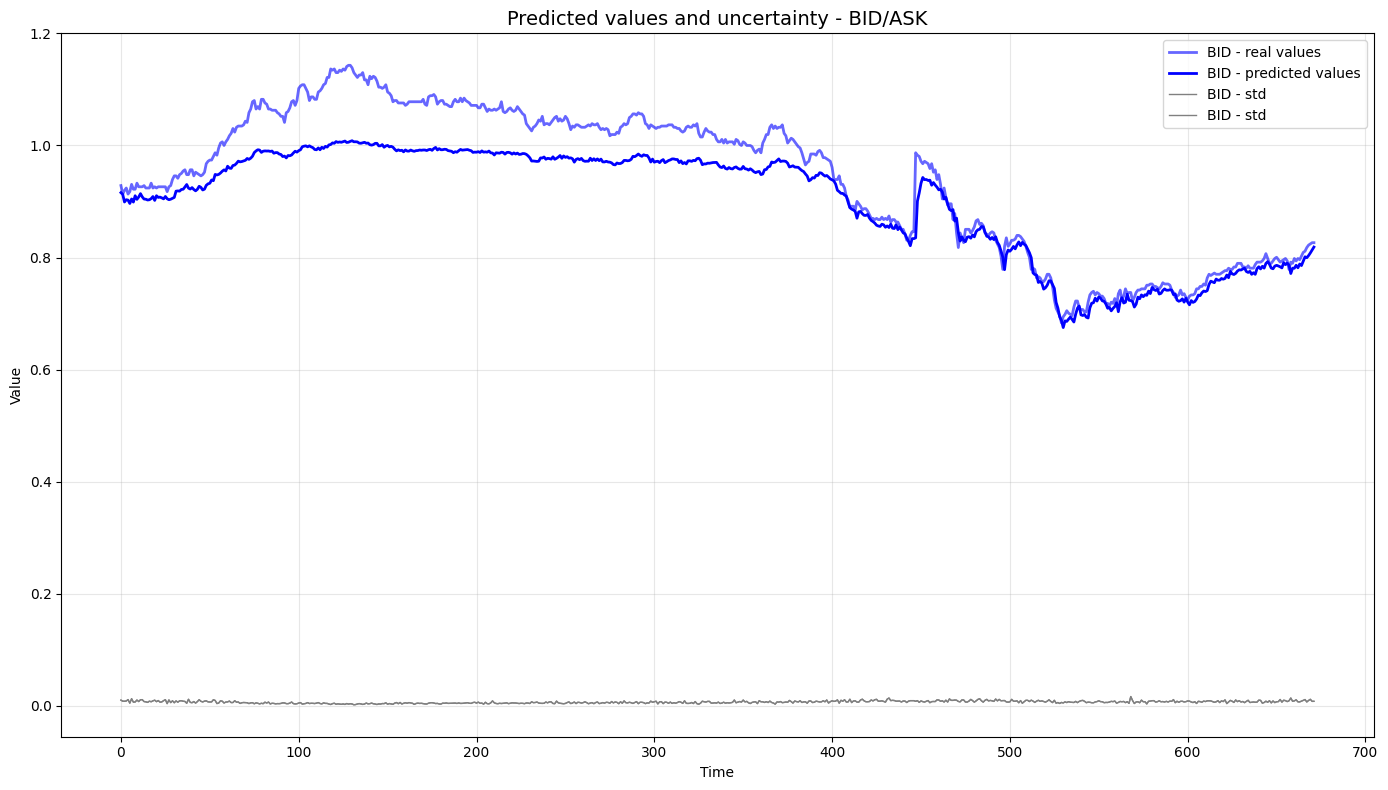

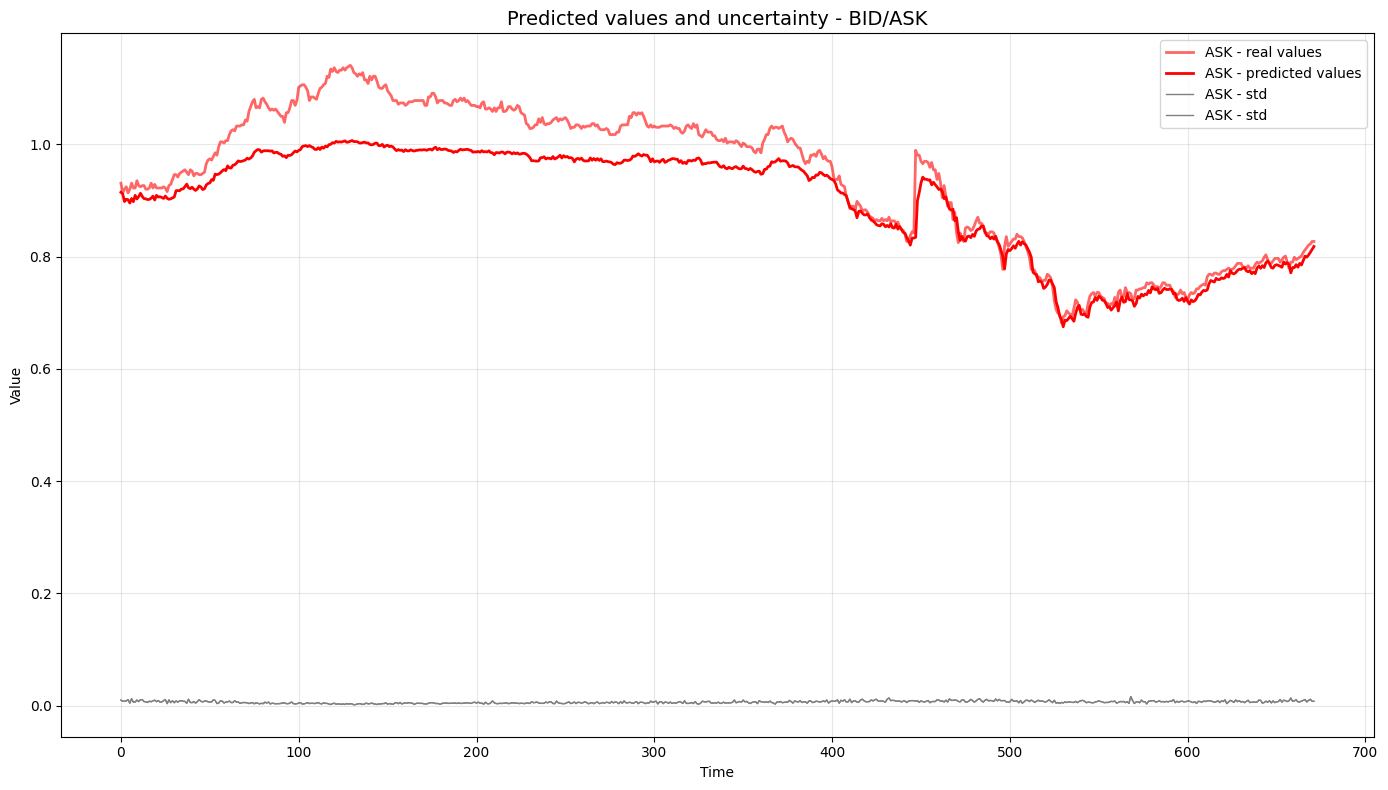

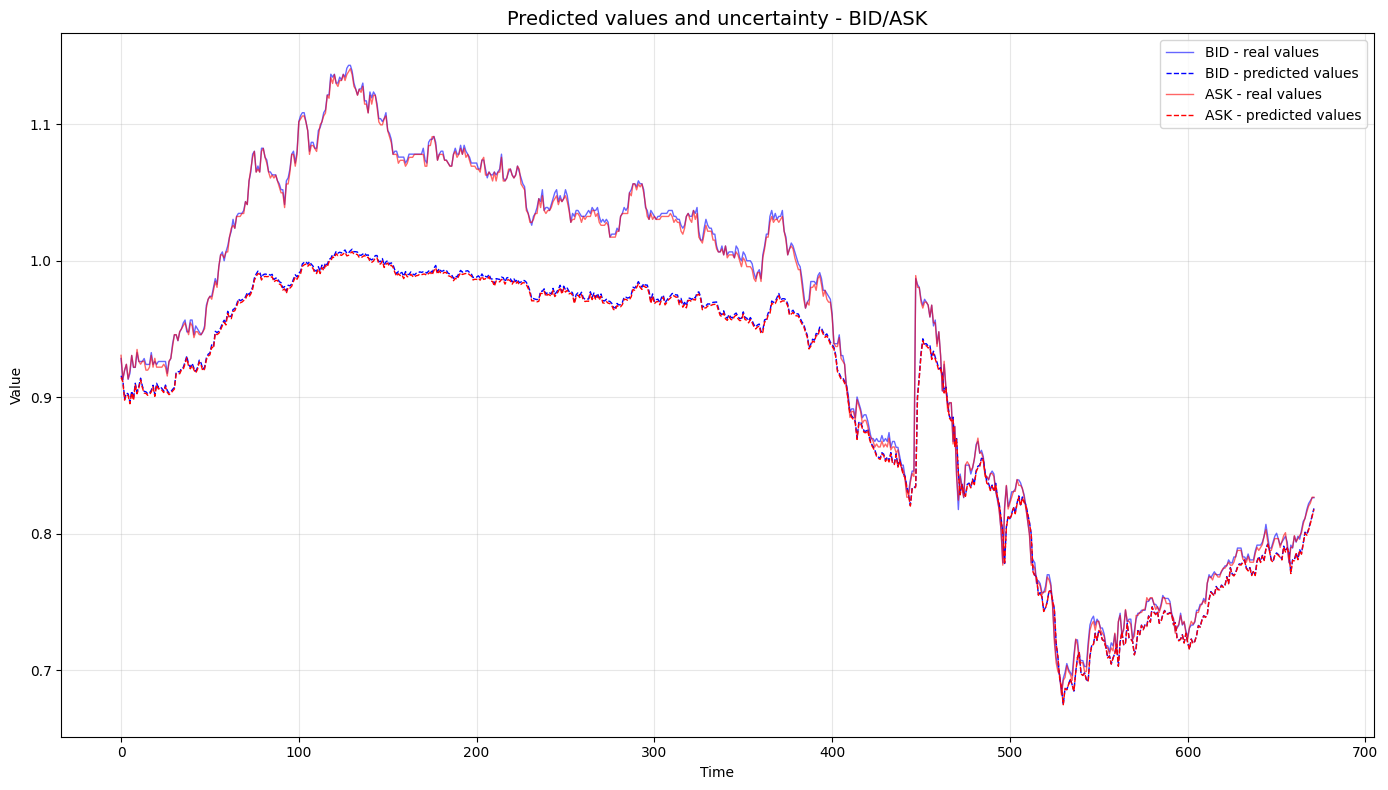

In [ ]:
plot_distributions(bnn_ts_valid, mean_valid, std_valid, max_points=(len(bnn_ts_valid)))

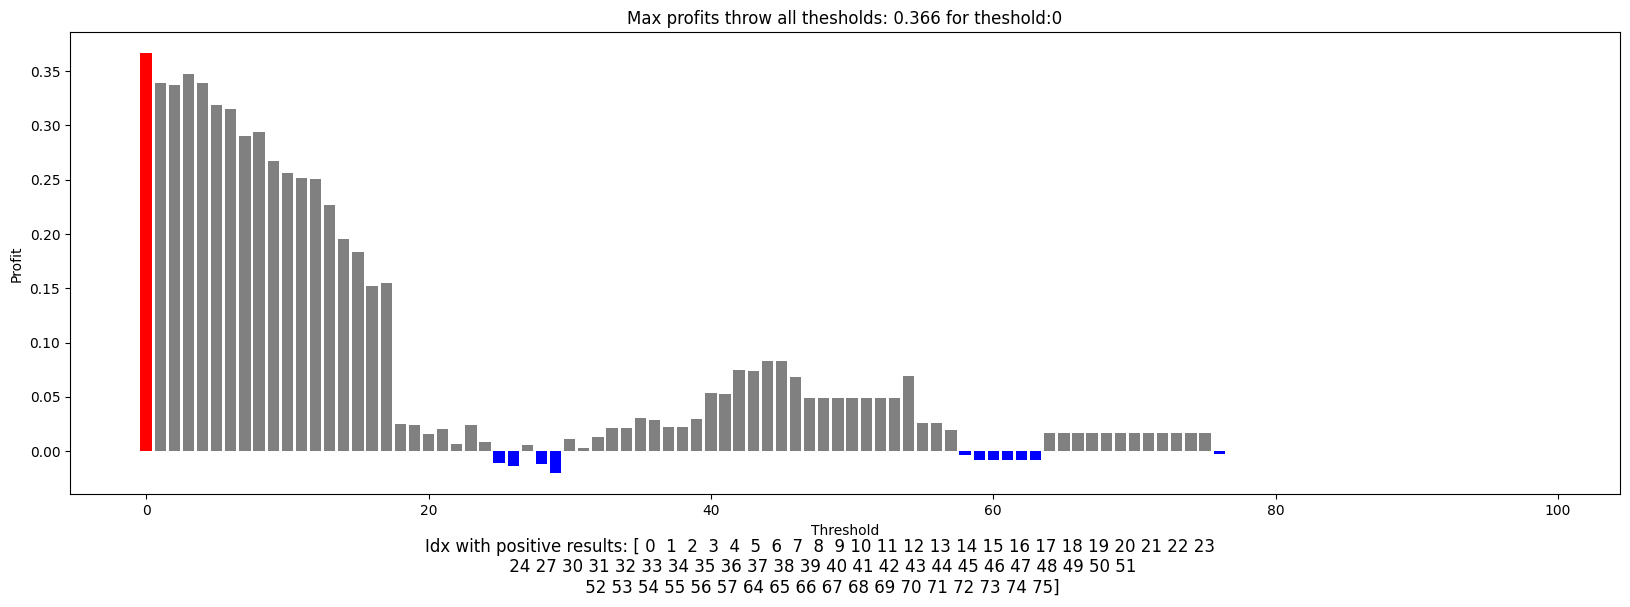

In [ ]:
plot_strategy(bnn_ts_valid, std_valid, mean_valid)

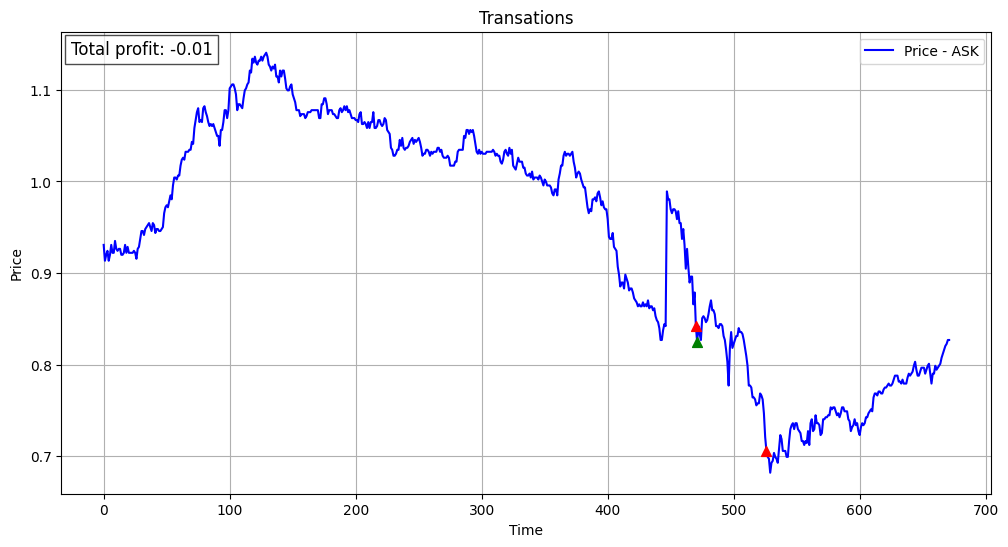

In [ ]:
total_profit, transactions = bnn_eval_strategy(bnn_ts_valid, std_valid, mean_valid,threshold=0.6)
plot_buy_points_with_profits(bnn_ts_valid, transactions, total_profit)


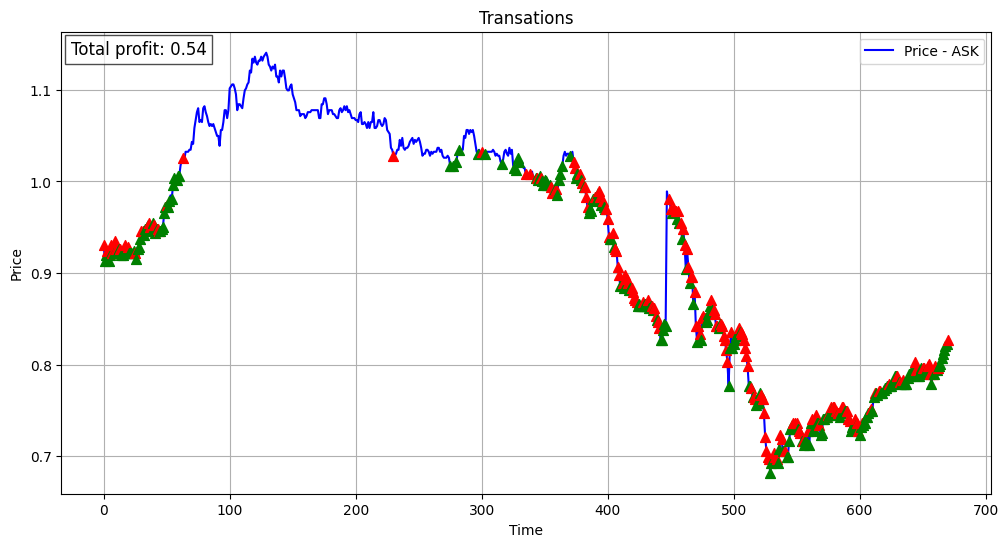

In [ ]:
total_profit, transactions = bnn_eval_strategy(bnn_ts_valid, std_valid, mean_valid,threshold=0)
plot_buy_points_with_profits(bnn_ts_valid, transactions, total_profit)


In [ ]:
mean_train, std_train, bnn_ts_train  = generate_results_nondeterministic(train_ts_scaled, bnn_model, true_to_predict=True)

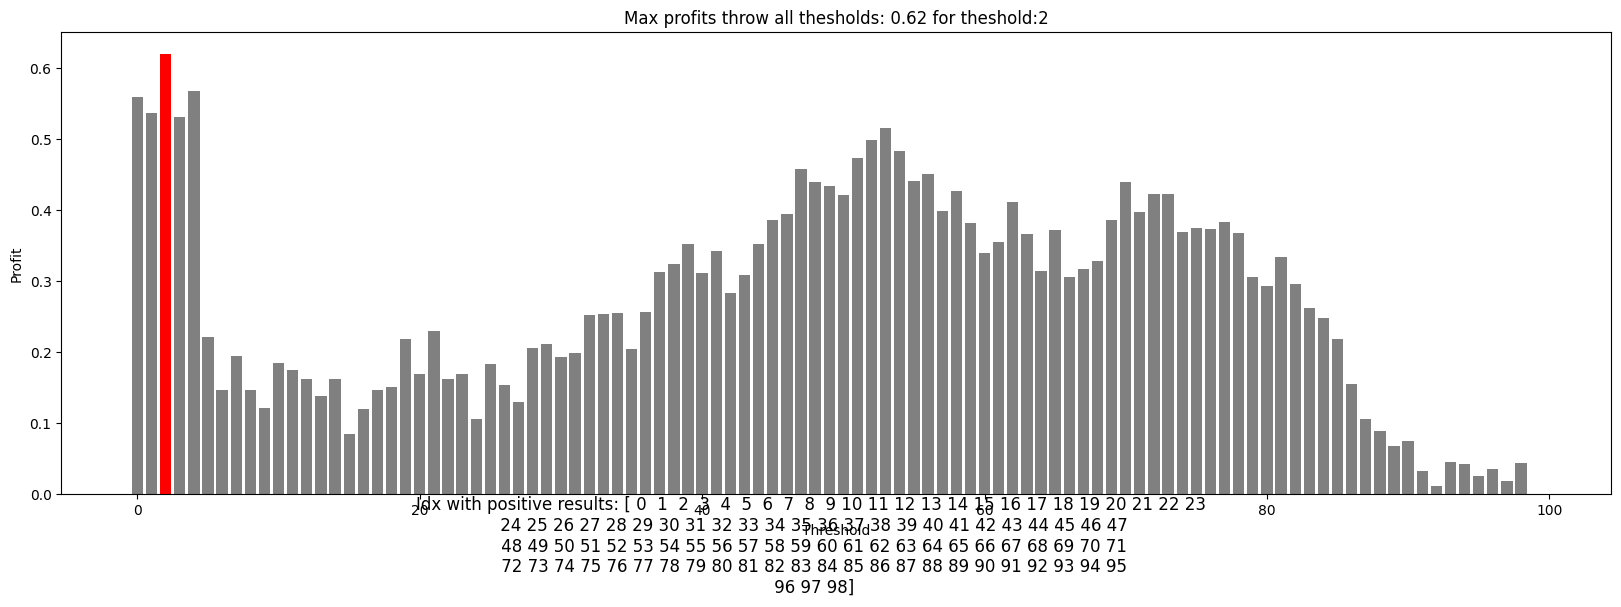

In [ ]:
plot_strategy(bnn_ts_train, std_train, mean_train)

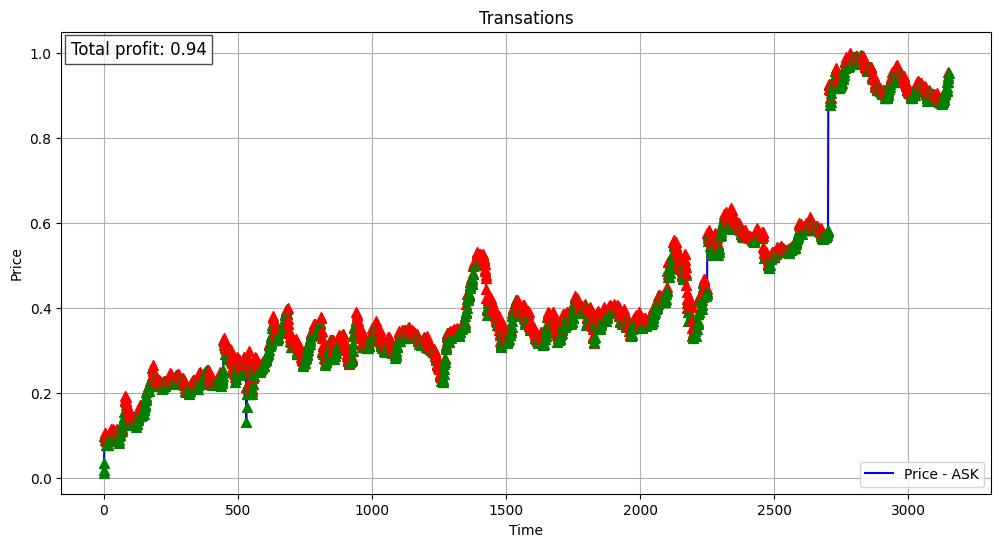

In [ ]:
total_profit, transactions = bnn_eval_strategy(bnn_ts_train, std_train, mean_train,threshold=0)
plot_buy_points_with_profits(bnn_ts_train, transactions, total_profit)


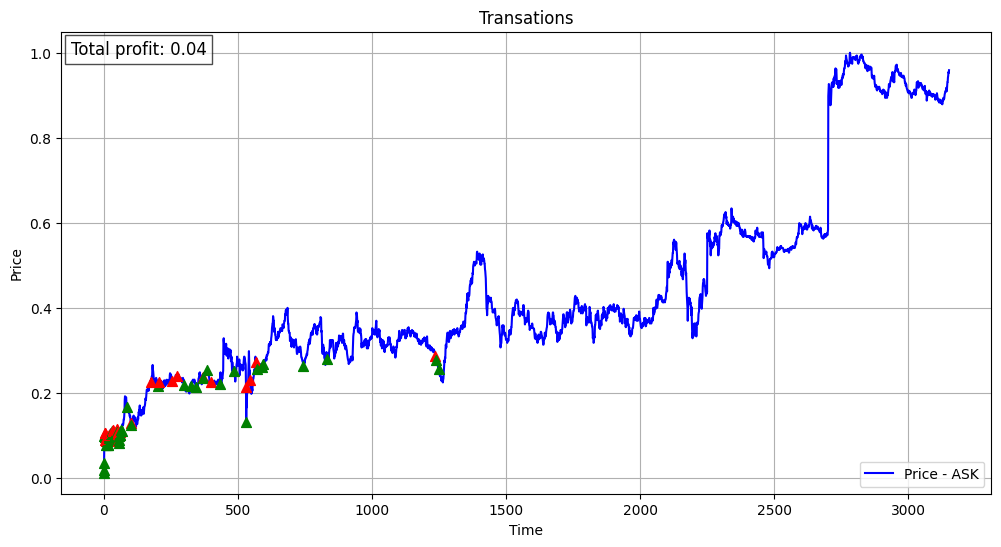

In [ ]:
total_profit, transactions = bnn_eval_strategy(bnn_ts_train, std_train, mean_train,threshold=0.95)
plot_buy_points_with_profits(bnn_ts_train, transactions, total_profit)


In [ ]:
x_size = len(df)
train_limit_final = 0.85
test_limit_final = 0.15

train_end_final = int(x_size * train_limit_final)

train_ts_final = df[:train_end_final]
test_ts_final = df[train_end_final:]

scaler = MinMaxScaler()
train_ts_scaled_final = scaler.fit_transform(train_ts_final)
test_ts_scaled_final = scaler.transform(test_ts_final)

train_sampler_final = Sampler(train_ts_scaled_final, features=2)
test_sampler_final = Sampler(test_ts_scaled_final, features=2)

X_train_final, y_train_final = train_sampler_final.create_sequences()
X_test_final, y_test_final = test_sampler_final.create_sequences()

X_train_final = torch.tensor(X_train_final, dtype=torch.float32)
y_train_final = torch.tensor(y_train_final, dtype=torch.float32)

X_test_final = torch.tensor(X_test_final, dtype=torch.float32)
y_test_final = torch.tensor(y_test_final, dtype=torch.float32)

train_dataset_final = TensorDataset(X_train_final, y_train_final)
test_dataset_final = TensorDataset(X_test_final, y_test_final)

trainloader_final = DataLoader(train_dataset_final, batch_size=16, shuffle=True)
testloader_final = DataLoader(test_dataset_final, batch_size=16)

params = study.best_trial.params
bnn_model_final = BLSTM(input_size=2, hidden_size=params["hidden_size"], dense_layers=[params["hidden_size"], 10,2], num_samples=7, num_layers=1, prior_mu=params["prior_mu"], prior_log_std=params["prior_log_std"])

In [ ]:
optimizer = torch.optim.Adam(bnn_model_final.parameters(), lr=params["lr"])
bnn_model_final, _ = train_bnn(bnn_model_final, trainloader_final, testloader_final, optimizer, epochs=200, kl_weight_end=0.01, patience=20)

Epoch 1/200
  Train - Total: 0.022093, MSE: 0.022093, KL: 0.325551
  Val MSE: 0.009669, KL weight: 0.000000
Epoch 11/200
  Train - Total: 0.000731, MSE: 0.000506, KL: 0.225244
  Val MSE: 0.000540, KL weight: 0.001000
Epoch 21/200
  Train - Total: 0.000637, MSE: 0.000433, KL: 0.102081
  Val MSE: 0.000090, KL weight: 0.002000
Epoch 31/200
  Train - Total: 0.000460, MSE: 0.000282, KL: 0.059543
  Val MSE: 0.000152, KL weight: 0.003000
Epoch 41/200
  Train - Total: 0.000553, MSE: 0.000336, KL: 0.054221
  Val MSE: 0.000129, KL weight: 0.004000
Early stopping at epoch 41


In [ ]:
mean_final, std_final, bnn_ts_final  = generate_results_nondeterministic(test_ts_scaled_final, bnn_model_final, true_to_predict=True)

real_values: (673, 2)
mean: (673, 2)
std: (673, 2)


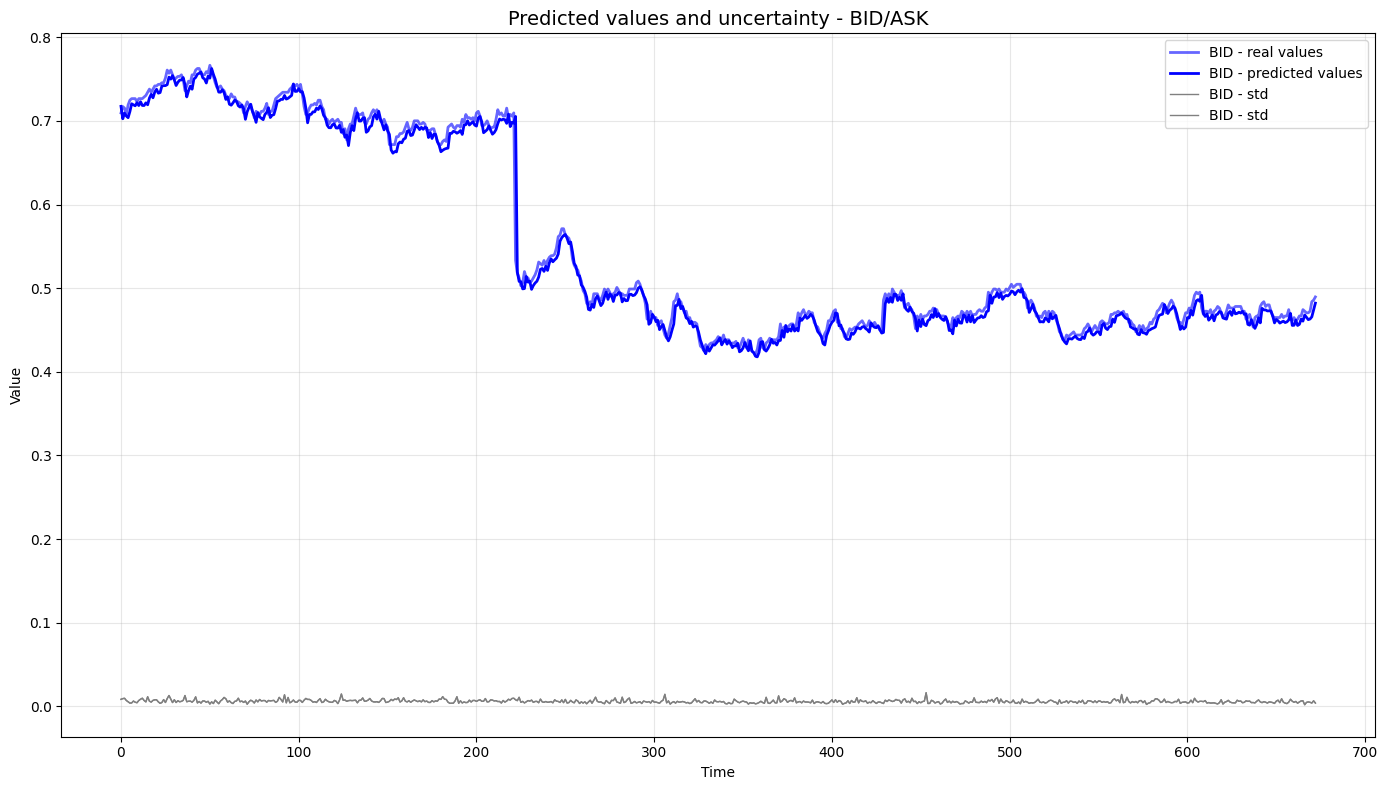

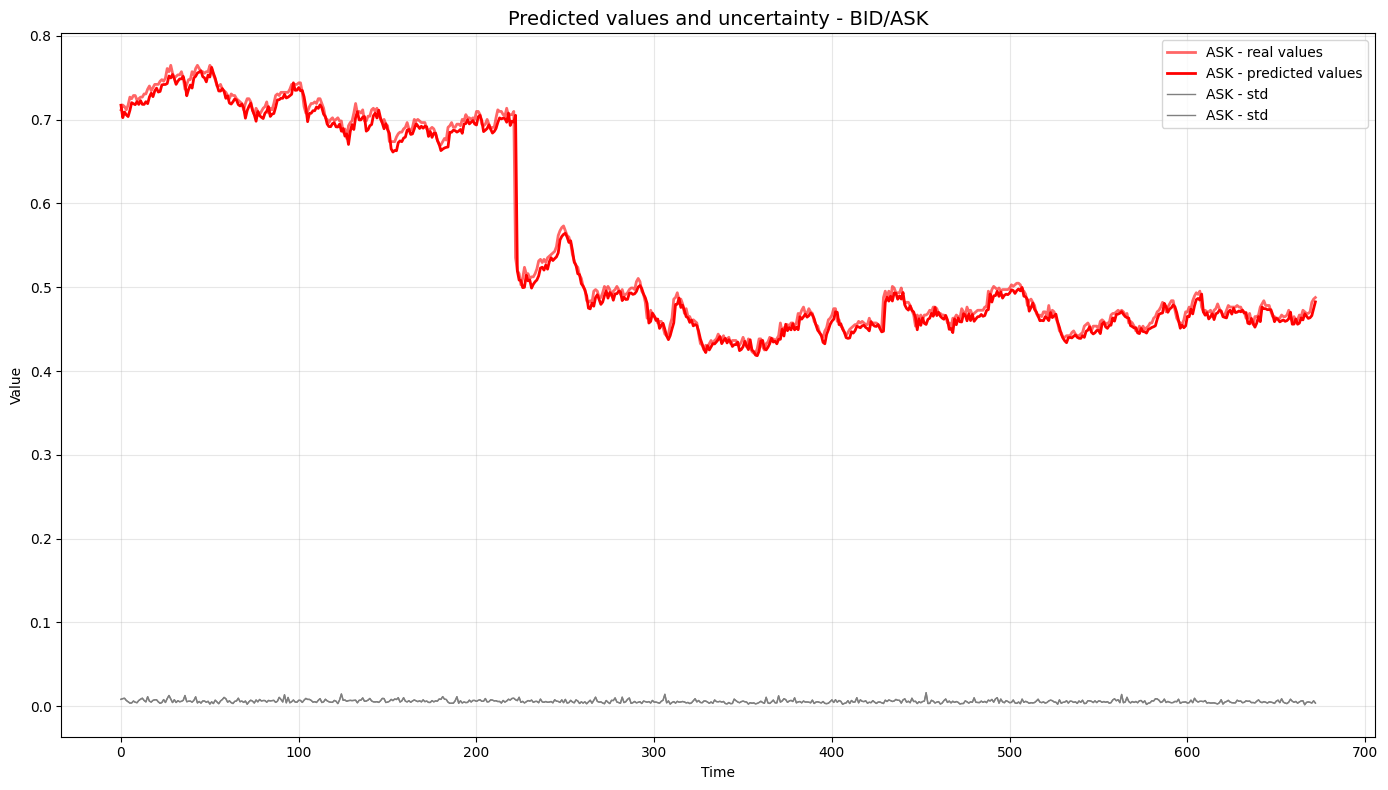

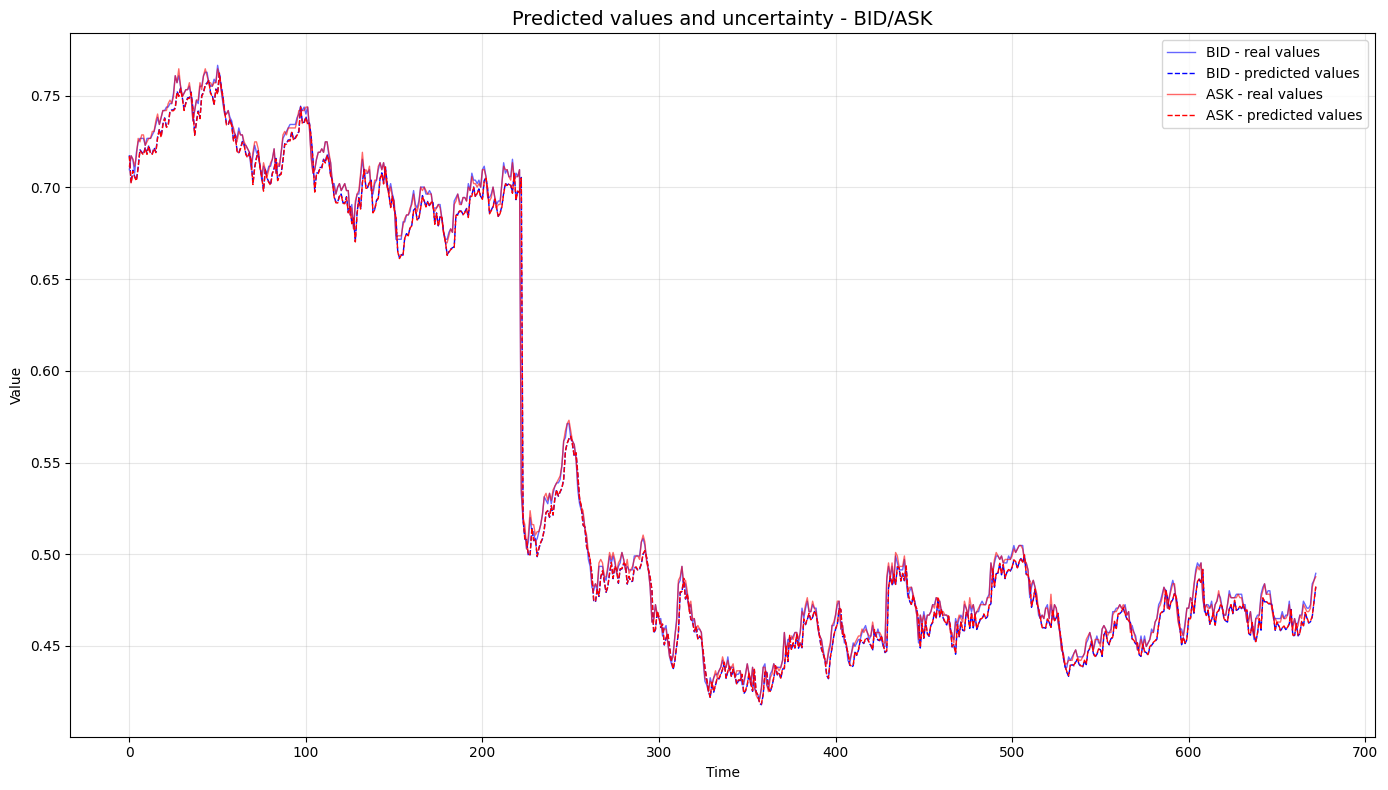

In [ ]:
plot_distributions(bnn_ts_final, mean_final, std_final, max_points=(len(bnn_ts_final)))

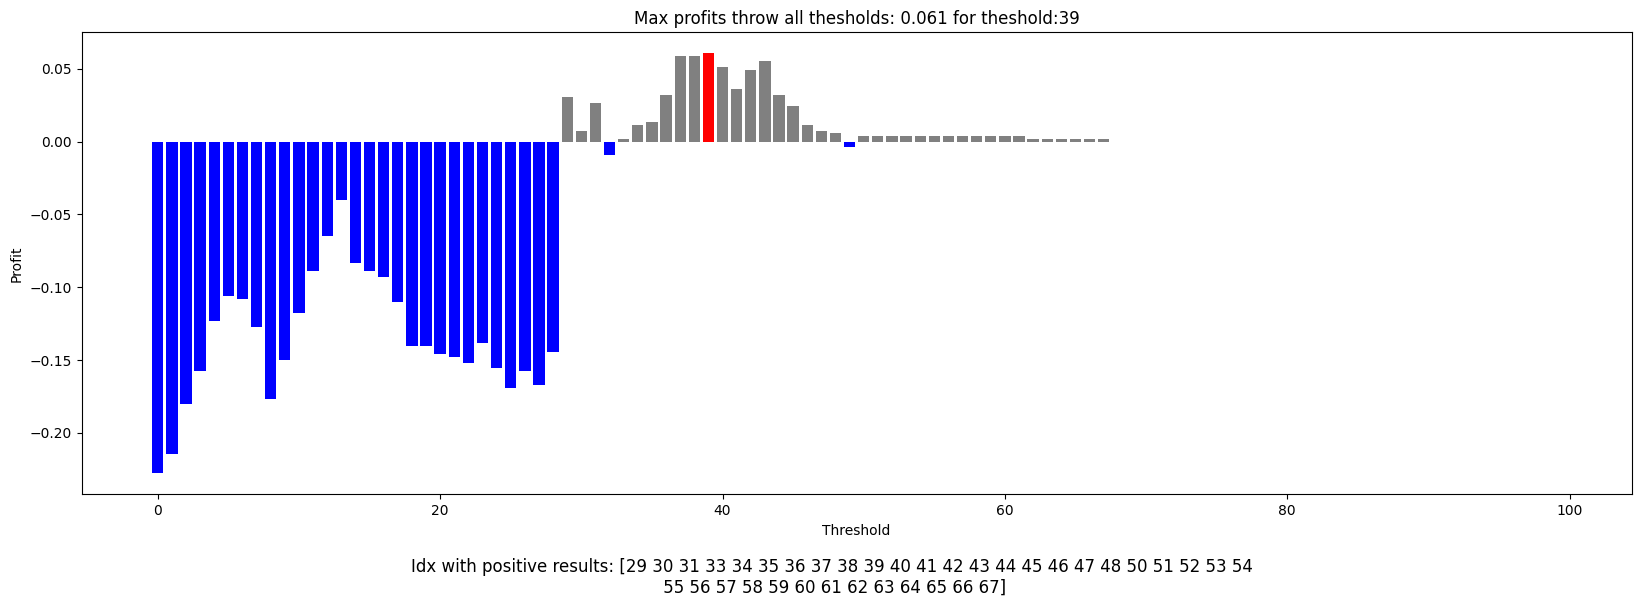

In [ ]:
plot_strategy(bnn_ts_final, std_final, mean_final)

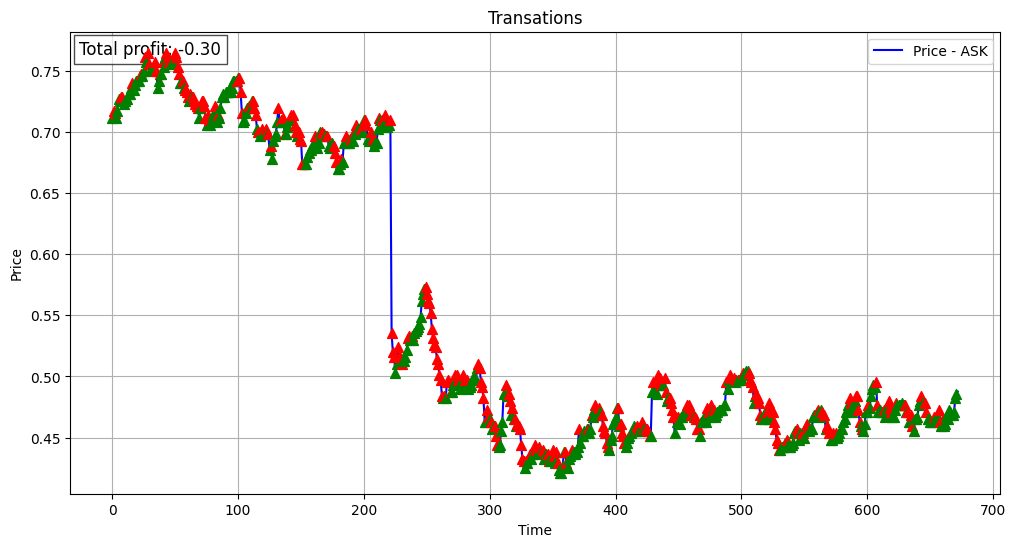

In [ ]:
total_profit, transactions = bnn_eval_strategy(bnn_ts_final, std_final, mean_final,threshold=0.0)
plot_buy_points_with_profits(bnn_ts_final, transactions, total_profit)


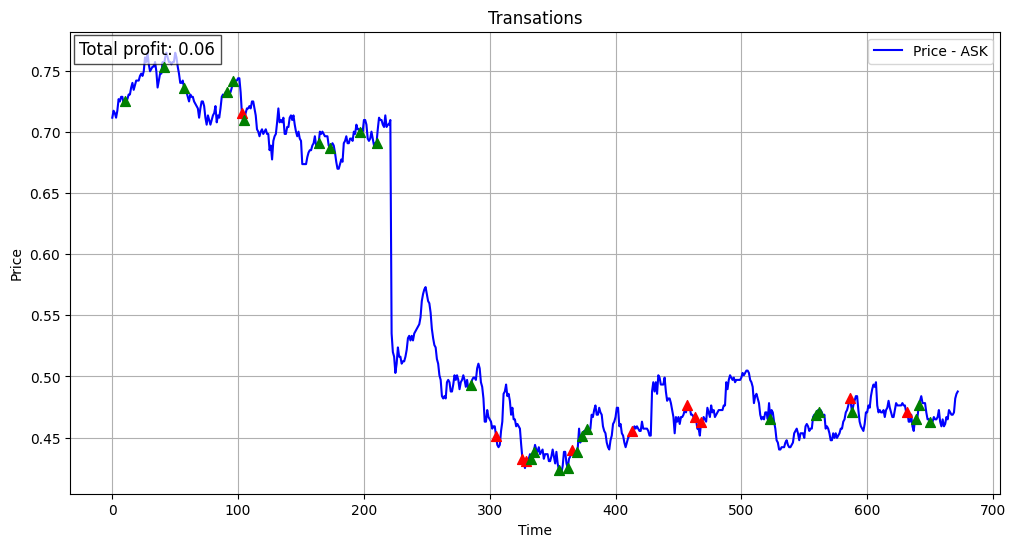

In [ ]:
total_profit, transactions = bnn_eval_strategy(bnn_ts_final, std_final, mean_final,threshold=0.39)
plot_buy_points_with_profits(bnn_ts_final, transactions, total_profit)


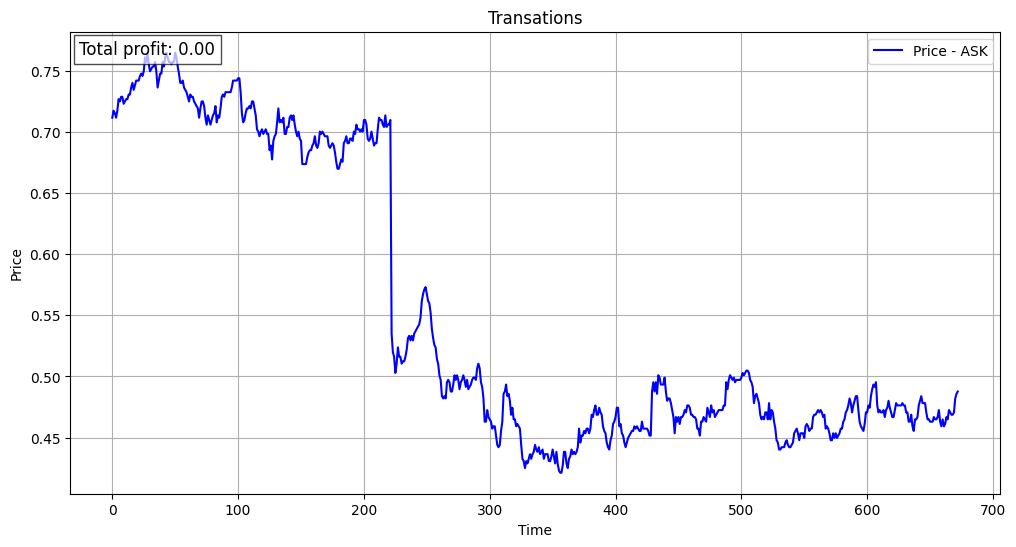

In [ ]:
total_profit, transactions = bnn_eval_strategy(bnn_ts_final, std_final, mean_final,threshold=0.8)
plot_buy_points_with_profits(bnn_ts_final, transactions, total_profit)


In [ ]:
torch.save(bnn_model_final.state_dict(), 'model.pth')

from google.colab import files
files.download('model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Baseline

In [ ]:
def train_lstm(model, trainloader, valloader, optimizer, epochs=100, patience=25):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x_batch, y_batch in trainloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).squeeze(1)

            optimizer.zero_grad()
            output = model(x_batch)

            loss = F.mse_loss(output, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(trainloader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in valloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).squeeze(1)
                output = model(x_batch)

                loss = F.mse_loss(output, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valloader)

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train MSE: {avg_train_loss:.6f}")
            print(f"  Val MSE:   {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return model, avg_val_loss


In [ ]:
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 15, 30)
    lr = trial.suggest_float("lr", 0.01, 0.05)
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.1)

    model = LSTM(
        input_size=2,
        hidden_size=hidden_size,
        dense_layers=[hidden_size, 10, 2],
        num_layers=1,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    _, avg_val_loss = train_lstm(
        model,
        trainloader,
        valloader,
        optimizer,
        epochs=50,
        patience=25
    )


    return avg_val_loss


In [ ]:
study_lstm = optuna.create_study(direction="minimize")
study_lstm.optimize(objective, n_trials=40)

print("Best trial:")
print(study_lstm.best_trial)

[I 2025-06-18 22:47:16,619] A new study created in memory with name: no-name-ff37efd2-971a-4d89-a073-e744edbcc6d1


Epoch 1/50
  Train MSE: 0.063355
  Val MSE:   0.314583
Epoch 11/50
  Train MSE: 0.057206
  Val MSE:   0.243460
Epoch 21/50
  Train MSE: 0.057695
  Val MSE:   0.056761
Epoch 31/50
  Train MSE: 0.056895
  Val MSE:   0.219993
Epoch 41/50
  Train MSE: 0.054447
  Val MSE:   0.316578


[I 2025-06-18 22:47:45,963] Trial 0 finished with value: 0.32091134041547775 and parameters: {'hidden_size': 19, 'lr': 0.03233282684746407, 'weight_decay': 0.09481263146914908}. Best is trial 0 with value: 0.32091134041547775.


Early stopping at epoch 46
Epoch 1/50
  Train MSE: 0.059504
  Val MSE:   0.291158
Epoch 11/50
  Train MSE: 0.059683
  Val MSE:   0.343334
Epoch 21/50
  Train MSE: 0.058699
  Val MSE:   0.276184
Epoch 31/50
  Train MSE: 0.057798
  Val MSE:   0.263864


[I 2025-06-18 22:48:09,469] Trial 1 finished with value: 0.387993665323371 and parameters: {'hidden_size': 26, 'lr': 0.040277425294705495, 'weight_decay': 0.061985299425015024}. Best is trial 0 with value: 0.32091134041547775.


Early stopping at epoch 38
Epoch 1/50
  Train MSE: 0.061073
  Val MSE:   0.383628
Epoch 11/50
  Train MSE: 0.056722
  Val MSE:   0.063545
Epoch 21/50
  Train MSE: 0.056269
  Val MSE:   0.430481
Epoch 31/50
  Train MSE: 0.058498
  Val MSE:   0.330993
Epoch 41/50
  Train MSE: 0.057485
  Val MSE:   0.300583


[I 2025-06-18 22:48:40,551] Trial 2 finished with value: 0.44014563659826916 and parameters: {'hidden_size': 27, 'lr': 0.0370457262629279, 'weight_decay': 0.03791527618335755}. Best is trial 0 with value: 0.32091134041547775.


Epoch 1/50
  Train MSE: 0.060192
  Val MSE:   0.191467
Epoch 11/50
  Train MSE: 0.061506
  Val MSE:   0.278561
Epoch 21/50
  Train MSE: 0.059717
  Val MSE:   0.128526
Epoch 31/50
  Train MSE: 0.059620
  Val MSE:   0.143651


[I 2025-06-18 22:49:02,389] Trial 3 finished with value: 0.4816493984489214 and parameters: {'hidden_size': 16, 'lr': 0.04492129620273313, 'weight_decay': 0.024951931369969274}. Best is trial 0 with value: 0.32091134041547775.


Early stopping at epoch 35
Epoch 1/50
  Train MSE: 0.058492
  Val MSE:   0.342009
Epoch 11/50
  Train MSE: 0.056740
  Val MSE:   0.373189
Epoch 21/50
  Train MSE: 0.057339
  Val MSE:   0.332433
Epoch 31/50
  Train MSE: 0.055954
  Val MSE:   0.382623


[I 2025-06-18 22:49:25,325] Trial 4 finished with value: 0.33831161952444483 and parameters: {'hidden_size': 30, 'lr': 0.030874504807637787, 'weight_decay': 0.0812558382021116}. Best is trial 0 with value: 0.32091134041547775.


Early stopping at epoch 37
Epoch 1/50
  Train MSE: 0.059379
  Val MSE:   0.344693
Epoch 11/50
  Train MSE: 0.057608
  Val MSE:   0.234490
Epoch 21/50
  Train MSE: 0.055606
  Val MSE:   0.236165
Epoch 31/50
  Train MSE: 0.056158
  Val MSE:   0.327139


[I 2025-06-18 22:49:45,834] Trial 5 finished with value: 0.3664480284565971 and parameters: {'hidden_size': 16, 'lr': 0.022701833304722453, 'weight_decay': 0.04281867427321916}. Best is trial 0 with value: 0.32091134041547775.


Early stopping at epoch 33
Epoch 1/50
  Train MSE: 0.062577
  Val MSE:   0.270930
Epoch 11/50
  Train MSE: 0.056308
  Val MSE:   0.219065
Epoch 21/50
  Train MSE: 0.056254
  Val MSE:   0.302506


[I 2025-06-18 22:50:03,121] Trial 6 finished with value: 0.31984496861696243 and parameters: {'hidden_size': 16, 'lr': 0.019773403846226088, 'weight_decay': 0.028867467572828105}. Best is trial 6 with value: 0.31984496861696243.


Early stopping at epoch 28
Epoch 1/50
  Train MSE: 0.056540
  Val MSE:   0.342274
Epoch 11/50
  Train MSE: 0.054662
  Val MSE:   0.329970
Epoch 21/50
  Train MSE: 0.055524
  Val MSE:   0.217077
Epoch 31/50
  Train MSE: 0.057803
  Val MSE:   0.294102
Epoch 41/50
  Train MSE: 0.055578
  Val MSE:   0.272523


[I 2025-06-18 22:50:34,189] Trial 7 finished with value: 0.3460755692351432 and parameters: {'hidden_size': 17, 'lr': 0.020614221492670885, 'weight_decay': 0.04450624942527696}. Best is trial 6 with value: 0.31984496861696243.


Epoch 1/50
  Train MSE: 0.062125
  Val MSE:   0.277431
Epoch 11/50
  Train MSE: 0.056074
  Val MSE:   0.237729
Epoch 21/50
  Train MSE: 0.055177
  Val MSE:   0.291643
Epoch 31/50
  Train MSE: 0.057911
  Val MSE:   0.243486


[I 2025-06-18 22:50:54,816] Trial 8 finished with value: 0.29324492155796006 and parameters: {'hidden_size': 21, 'lr': 0.0205269801434372, 'weight_decay': 0.04086222009914485}. Best is trial 8 with value: 0.29324492155796006.


Early stopping at epoch 33
Epoch 1/50
  Train MSE: 0.061470
  Val MSE:   0.195166
Epoch 11/50
  Train MSE: 0.057887
  Val MSE:   0.341165
Epoch 21/50
  Train MSE: 0.058185
  Val MSE:   0.224583
Epoch 31/50
  Train MSE: 0.059407
  Val MSE:   0.166186
Epoch 41/50
  Train MSE: 0.060214
  Val MSE:   0.313503


[I 2025-06-18 22:51:21,464] Trial 9 finished with value: 0.2346383198386147 and parameters: {'hidden_size': 23, 'lr': 0.04894447159878909, 'weight_decay': 0.07983668259164627}. Best is trial 9 with value: 0.2346383198386147.


Early stopping at epoch 43
Epoch 1/50
  Train MSE: 0.064010
  Val MSE:   0.369586
Epoch 11/50
  Train MSE: 0.056614
  Val MSE:   0.352992
Epoch 21/50
  Train MSE: 0.057009
  Val MSE:   0.440893
Epoch 31/50
  Train MSE: 0.060523
  Val MSE:   0.247680


[I 2025-06-18 22:51:41,514] Trial 10 finished with value: 0.15797059588311685 and parameters: {'hidden_size': 24, 'lr': 0.04981058646105558, 'weight_decay': 0.06804676128754589}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 32
Epoch 1/50
  Train MSE: 0.059453
  Val MSE:   0.278497
Epoch 11/50
  Train MSE: 0.058872
  Val MSE:   0.125473
Epoch 21/50
  Train MSE: 0.060091
  Val MSE:   0.163101
Epoch 31/50
  Train MSE: 0.057648
  Val MSE:   0.330856


[I 2025-06-18 22:52:04,503] Trial 11 finished with value: 0.43364921105759485 and parameters: {'hidden_size': 24, 'lr': 0.047844875886743105, 'weight_decay': 0.07272430433275}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 37
Epoch 1/50
  Train MSE: 0.058452
  Val MSE:   0.235699
Epoch 11/50
  Train MSE: 0.058362
  Val MSE:   0.368431
Epoch 21/50
  Train MSE: 0.056567
  Val MSE:   0.460771
Epoch 31/50
  Train MSE: 0.059506
  Val MSE:   0.214289


[I 2025-06-18 22:52:27,468] Trial 12 finished with value: 0.2899990475603512 and parameters: {'hidden_size': 22, 'lr': 0.049471877558804986, 'weight_decay': 0.09923748273358046}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 37
Epoch 1/50
  Train MSE: 0.060100
  Val MSE:   0.267093
Epoch 11/50
  Train MSE: 0.058005
  Val MSE:   0.442191
Epoch 21/50
  Train MSE: 0.057282
  Val MSE:   0.226966
Epoch 31/50
  Train MSE: 0.057127
  Val MSE:   0.299013
Epoch 41/50
  Train MSE: 0.057475
  Val MSE:   0.352695


[I 2025-06-18 22:52:59,084] Trial 13 finished with value: 0.32721869984552976 and parameters: {'hidden_size': 24, 'lr': 0.04198796579970487, 'weight_decay': 0.0634731418657051}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.057224
  Val MSE:   0.324981
Epoch 11/50
  Train MSE: 0.054787
  Val MSE:   0.203877
Epoch 21/50
  Train MSE: 0.055529
  Val MSE:   0.208814
Epoch 31/50
  Train MSE: 0.053887
  Val MSE:   0.227255


[I 2025-06-18 22:53:21,372] Trial 14 finished with value: 0.2580317081440063 and parameters: {'hidden_size': 27, 'lr': 0.01067868046492514, 'weight_decay': 0.07976122409459643}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 36
Epoch 1/50
  Train MSE: 0.057350
  Val MSE:   0.329207
Epoch 11/50
  Train MSE: 0.057348
  Val MSE:   0.074179
Epoch 21/50
  Train MSE: 0.055453
  Val MSE:   0.341203


[I 2025-06-18 22:53:38,133] Trial 15 finished with value: 0.3144812257516952 and parameters: {'hidden_size': 19, 'lr': 0.03733874514738088, 'weight_decay': 0.01106479113210481}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 27
Epoch 1/50
  Train MSE: 0.060284
  Val MSE:   0.261898
Epoch 11/50
  Train MSE: 0.056076
  Val MSE:   0.217118
Epoch 21/50
  Train MSE: 0.058078
  Val MSE:   0.126142
Epoch 31/50
  Train MSE: 0.057134
  Val MSE:   0.082996
Epoch 41/50
  Train MSE: 0.058889
  Val MSE:   0.361012


[I 2025-06-18 22:54:09,093] Trial 16 finished with value: 0.21795553847083024 and parameters: {'hidden_size': 25, 'lr': 0.04563275855520743, 'weight_decay': 0.08740240268100115}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.059167
  Val MSE:   0.387413
Epoch 11/50
  Train MSE: 0.056169
  Val MSE:   0.352664
Epoch 21/50
  Train MSE: 0.057753
  Val MSE:   0.430515
Epoch 31/50
  Train MSE: 0.056679
  Val MSE:   0.277616
Epoch 41/50
  Train MSE: 0.058309
  Val MSE:   0.337232


[I 2025-06-18 22:54:40,448] Trial 17 finished with value: 0.25122936211881186 and parameters: {'hidden_size': 26, 'lr': 0.042917963201087685, 'weight_decay': 0.09076466111940791}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.064870
  Val MSE:   0.235421
Epoch 11/50
  Train MSE: 0.058034
  Val MSE:   0.260158
Epoch 21/50
  Train MSE: 0.059305
  Val MSE:   0.239433
Epoch 31/50
  Train MSE: 0.057928
  Val MSE:   0.251389


[I 2025-06-18 22:55:02,614] Trial 18 finished with value: 0.35592576542070936 and parameters: {'hidden_size': 28, 'lr': 0.026511604426973697, 'weight_decay': 0.05613592263532932}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 35
Epoch 1/50
  Train MSE: 0.059211
  Val MSE:   0.488479
Epoch 11/50
  Train MSE: 0.059662
  Val MSE:   0.413692
Epoch 21/50
  Train MSE: 0.054667
  Val MSE:   0.365018


[I 2025-06-18 22:55:22,132] Trial 19 finished with value: 0.2868403787059443 and parameters: {'hidden_size': 29, 'lr': 0.03428959588360982, 'weight_decay': 0.06688608029794893}. Best is trial 10 with value: 0.15797059588311685.


Epoch 31/50
  Train MSE: 0.056942
  Val MSE:   0.286840
Early stopping at epoch 31
Epoch 1/50
  Train MSE: 0.061277
  Val MSE:   0.469417
Epoch 11/50
  Train MSE: 0.059984
  Val MSE:   0.363701
Epoch 21/50
  Train MSE: 0.059203
  Val MSE:   0.216522
Epoch 31/50
  Train MSE: 0.060851
  Val MSE:   0.271440
Epoch 41/50
  Train MSE: 0.056981
  Val MSE:   0.313354


[I 2025-06-18 22:55:53,142] Trial 20 finished with value: 0.3427252847523916 and parameters: {'hidden_size': 25, 'lr': 0.04654648154575889, 'weight_decay': 0.08724421846329208}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.061078
  Val MSE:   0.164235
Epoch 11/50
  Train MSE: 0.057430
  Val MSE:   0.383944
Epoch 21/50
  Train MSE: 0.058666
  Val MSE:   0.376479


[I 2025-06-18 22:56:09,329] Trial 21 finished with value: 0.40303183772734236 and parameters: {'hidden_size': 23, 'lr': 0.04958513872665954, 'weight_decay': 0.07989820995133717}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 26
Epoch 1/50
  Train MSE: 0.059686
  Val MSE:   0.325795
Epoch 11/50
  Train MSE: 0.058891
  Val MSE:   0.273150
Epoch 21/50
  Train MSE: 0.057394
  Val MSE:   0.238942
Epoch 31/50
  Train MSE: 0.056532
  Val MSE:   0.361701
Epoch 41/50
  Train MSE: 0.059158
  Val MSE:   0.269694


[I 2025-06-18 22:56:40,529] Trial 22 finished with value: 0.41104752109164283 and parameters: {'hidden_size': 20, 'lr': 0.04514452727969487, 'weight_decay': 0.06935401608467662}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.065389
  Val MSE:   0.221924
Epoch 11/50
  Train MSE: 0.059661
  Val MSE:   0.300094
Epoch 21/50
  Train MSE: 0.056323
  Val MSE:   0.228632
Epoch 31/50
  Train MSE: 0.057095
  Val MSE:   0.333934


[I 2025-06-18 22:57:04,184] Trial 23 finished with value: 0.2782938187675817 and parameters: {'hidden_size': 23, 'lr': 0.039095273704992106, 'weight_decay': 0.07505183969407313}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 38
Epoch 1/50
  Train MSE: 0.057533
  Val MSE:   0.471865
Epoch 11/50
  Train MSE: 0.056491
  Val MSE:   0.217836
Epoch 21/50
  Train MSE: 0.058838
  Val MSE:   0.159731
Epoch 31/50
  Train MSE: 0.057113
  Val MSE:   0.230840


[I 2025-06-18 22:57:29,979] Trial 24 finished with value: 0.43005577261958805 and parameters: {'hidden_size': 22, 'lr': 0.04313743296505274, 'weight_decay': 0.08611935641953046}. Best is trial 10 with value: 0.15797059588311685.


Epoch 41/50
  Train MSE: 0.057623
  Val MSE:   0.430056
Early stopping at epoch 41
Epoch 1/50
  Train MSE: 0.059386
  Val MSE:   0.191723
Epoch 11/50
  Train MSE: 0.059190
  Val MSE:   0.274601
Epoch 21/50
  Train MSE: 0.057811
  Val MSE:   0.304504
Epoch 31/50
  Train MSE: 0.058973
  Val MSE:   0.057493
Epoch 41/50
  Train MSE: 0.057405
  Val MSE:   0.328530


[I 2025-06-18 22:58:01,423] Trial 25 finished with value: 0.5867381330047335 and parameters: {'hidden_size': 25, 'lr': 0.04673146706057066, 'weight_decay': 0.052058091084193084}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.067963
  Val MSE:   0.282380
Epoch 11/50
  Train MSE: 0.063092
  Val MSE:   0.128402
Epoch 21/50
  Train MSE: 0.057208
  Val MSE:   0.215179
Epoch 31/50
  Train MSE: 0.058562
  Val MSE:   0.147619
Epoch 41/50
  Train MSE: 0.058417
  Val MSE:   0.259979


[I 2025-06-18 22:58:32,971] Trial 26 finished with value: 0.1907242713939576 and parameters: {'hidden_size': 24, 'lr': 0.04995821614140548, 'weight_decay': 0.05684930595457989}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.058268
  Val MSE:   0.297125
Epoch 11/50
  Train MSE: 0.061365
  Val MSE:   0.099883
Epoch 21/50
  Train MSE: 0.057060
  Val MSE:   0.430655
Epoch 31/50
  Train MSE: 0.057127
  Val MSE:   0.418757


[I 2025-06-18 22:58:52,957] Trial 27 finished with value: 0.2635574413552171 and parameters: {'hidden_size': 25, 'lr': 0.04444754081379467, 'weight_decay': 0.056094351189671175}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 32
Epoch 1/50
  Train MSE: 0.056510
  Val MSE:   0.254025
Epoch 11/50
  Train MSE: 0.053782
  Val MSE:   0.259865
Epoch 21/50
  Train MSE: 0.055255
  Val MSE:   0.269847


[I 2025-06-18 22:59:11,050] Trial 28 finished with value: 0.24713200064642088 and parameters: {'hidden_size': 21, 'lr': 0.013259620403690019, 'weight_decay': 0.048892388963839524}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 29
Epoch 1/50
  Train MSE: 0.060301
  Val MSE:   0.195642
Epoch 11/50
  Train MSE: 0.057499
  Val MSE:   0.374113
Epoch 21/50
  Train MSE: 0.056297
  Val MSE:   0.395463


[I 2025-06-18 22:59:29,331] Trial 29 finished with value: 0.15898896301431314 and parameters: {'hidden_size': 24, 'lr': 0.03356924202739004, 'weight_decay': 0.09590786309485895}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 29
Epoch 1/50
  Train MSE: 0.057045
  Val MSE:   0.259909
Epoch 11/50
  Train MSE: 0.055718
  Val MSE:   0.252165
Epoch 21/50
  Train MSE: 0.055870
  Val MSE:   0.424528
Epoch 31/50
  Train MSE: 0.056689
  Val MSE:   0.306340
Epoch 41/50
  Train MSE: 0.056997
  Val MSE:   0.260795


[I 2025-06-18 23:00:00,463] Trial 30 finished with value: 0.391096059410345 and parameters: {'hidden_size': 18, 'lr': 0.028905835741811207, 'weight_decay': 0.09693399303724454}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.064508
  Val MSE:   0.181816
Epoch 11/50
  Train MSE: 0.056698
  Val MSE:   0.295154
Epoch 21/50
  Train MSE: 0.056206
  Val MSE:   0.302915
Epoch 31/50
  Train MSE: 0.058431
  Val MSE:   0.135832


[I 2025-06-18 23:00:23,790] Trial 31 finished with value: 0.3930120954201335 and parameters: {'hidden_size': 24, 'lr': 0.03406498765647309, 'weight_decay': 0.09111920580119204}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 37
Epoch 1/50
  Train MSE: 0.061290
  Val MSE:   0.406880
Epoch 11/50
  Train MSE: 0.059177
  Val MSE:   0.380881
Epoch 21/50
  Train MSE: 0.057521
  Val MSE:   0.451466
Epoch 31/50
  Train MSE: 0.059856
  Val MSE:   0.281591
Epoch 41/50
  Train MSE: 0.059093
  Val MSE:   0.288026


[I 2025-06-18 23:00:55,168] Trial 32 finished with value: 0.2006574934791951 and parameters: {'hidden_size': 26, 'lr': 0.03954017649799603, 'weight_decay': 0.06271095345168799}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.066977
  Val MSE:   0.186159
Epoch 11/50
  Train MSE: 0.056448
  Val MSE:   0.323322
Epoch 21/50
  Train MSE: 0.056195
  Val MSE:   0.202407
Epoch 31/50
  Train MSE: 0.057357
  Val MSE:   0.275489


[I 2025-06-18 23:01:15,095] Trial 33 finished with value: 0.2428314649455604 and parameters: {'hidden_size': 27, 'lr': 0.0402097814566553, 'weight_decay': 0.05852273758617349}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 32
Epoch 1/50
  Train MSE: 0.060805
  Val MSE:   0.291275
Epoch 11/50
  Train MSE: 0.055268
  Val MSE:   0.059258
Epoch 21/50
  Train MSE: 0.055795
  Val MSE:   0.183828
Epoch 31/50
  Train MSE: 0.058668
  Val MSE:   0.304674


[I 2025-06-18 23:01:37,703] Trial 34 finished with value: 0.40676140217554 and parameters: {'hidden_size': 26, 'lr': 0.03451136751900698, 'weight_decay': 0.06422705524347704}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 36
Epoch 1/50
  Train MSE: 0.057600
  Val MSE:   0.297574
Epoch 11/50
  Train MSE: 0.058691
  Val MSE:   0.227760
Epoch 21/50
  Train MSE: 0.057017
  Val MSE:   0.279116
Epoch 31/50
  Train MSE: 0.056991
  Val MSE:   0.329905
Epoch 41/50
  Train MSE: 0.058043
  Val MSE:   0.353965


[I 2025-06-18 23:02:09,208] Trial 35 finished with value: 0.20828705751115367 and parameters: {'hidden_size': 28, 'lr': 0.026140686835626023, 'weight_decay': 0.06024191338724196}. Best is trial 10 with value: 0.15797059588311685.


Epoch 1/50
  Train MSE: 0.056711
  Val MSE:   0.354161
Epoch 11/50
  Train MSE: 0.057432
  Val MSE:   0.089002
Epoch 21/50
  Train MSE: 0.058975
  Val MSE:   0.240069
Epoch 31/50
  Train MSE: 0.057175
  Val MSE:   0.335939


[I 2025-06-18 23:02:32,048] Trial 36 finished with value: 0.35065519100143794 and parameters: {'hidden_size': 24, 'lr': 0.036392905130503604, 'weight_decay': 0.03531063159067227}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 36
Epoch 1/50
  Train MSE: 0.057486
  Val MSE:   0.123779
Epoch 11/50
  Train MSE: 0.055615
  Val MSE:   0.241383
Epoch 21/50
  Train MSE: 0.057000
  Val MSE:   0.320031
Epoch 31/50
  Train MSE: 0.055704
  Val MSE:   0.342332


[I 2025-06-18 23:02:56,703] Trial 37 finished with value: 0.38810765459423974 and parameters: {'hidden_size': 26, 'lr': 0.030975032710322377, 'weight_decay': 0.04835946624822679}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 39
Epoch 1/50
  Train MSE: 0.062898
  Val MSE:   0.202993
Epoch 11/50
  Train MSE: 0.056987
  Val MSE:   0.373218
Epoch 21/50
  Train MSE: 0.059429
  Val MSE:   0.357439


[I 2025-06-18 23:03:15,626] Trial 38 finished with value: 0.17937153293972924 and parameters: {'hidden_size': 21, 'lr': 0.041610952322322446, 'weight_decay': 0.07194317974725913}. Best is trial 10 with value: 0.15797059588311685.


Early stopping at epoch 30
Epoch 1/50
  Train MSE: 0.062720
  Val MSE:   0.204424
Epoch 11/50
  Train MSE: 0.057129
  Val MSE:   0.188701
Epoch 21/50
  Train MSE: 0.058291
  Val MSE:   0.333183
Epoch 31/50
  Train MSE: 0.057307
  Val MSE:   0.261639
Epoch 41/50
  Train MSE: 0.057536
  Val MSE:   0.101711


[I 2025-06-18 23:03:47,139] Trial 39 finished with value: 0.4208924103350866 and parameters: {'hidden_size': 21, 'lr': 0.042506330325040795, 'weight_decay': 0.07347514415177431}. Best is trial 10 with value: 0.15797059588311685.


Best trial:
FrozenTrial(number=10, state=1, values=[0.15797059588311685], datetime_start=datetime.datetime(2025, 6, 18, 22, 51, 21, 465262), datetime_complete=datetime.datetime(2025, 6, 18, 22, 51, 41, 514294), params={'hidden_size': 24, 'lr': 0.04981058646105558, 'weight_decay': 0.06804676128754589}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=30, log=False, low=15, step=1), 'lr': FloatDistribution(high=0.05, log=False, low=0.01, step=None), 'weight_decay': FloatDistribution(high=0.1, log=False, low=0.01, step=None)}, trial_id=10, value=None)


In [ ]:
params_lstm = study_lstm.best_trial.params
lstm_model = LSTM(input_size=2, hidden_size=params_lstm["hidden_size"], dense_layers=[params_lstm["hidden_size"], 10,2], num_layers=1)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=params_lstm["lr"], weight_decay=params_lstm["weight_decay"])
lstm_model, _ = train_lstm(lstm_model, trainloader, valloader, optimizer, epochs=100)

Epoch 1/100
  Train MSE: 0.061405
  Val MSE:   0.228160
Epoch 11/100
  Train MSE: 0.056926
  Val MSE:   0.189567
Epoch 21/100
  Train MSE: 0.057555
  Val MSE:   0.168011
Epoch 31/100
  Train MSE: 0.057660
  Val MSE:   0.232935
Epoch 41/100
  Train MSE: 0.058368
  Val MSE:   0.427486
Early stopping at epoch 50


In [ ]:
predictions_val, lstm_ts_val = generate_results_deterministic(val_ts_scaled, lstm_model, true_to_predict=True, seq_len=SEQ_LEN)


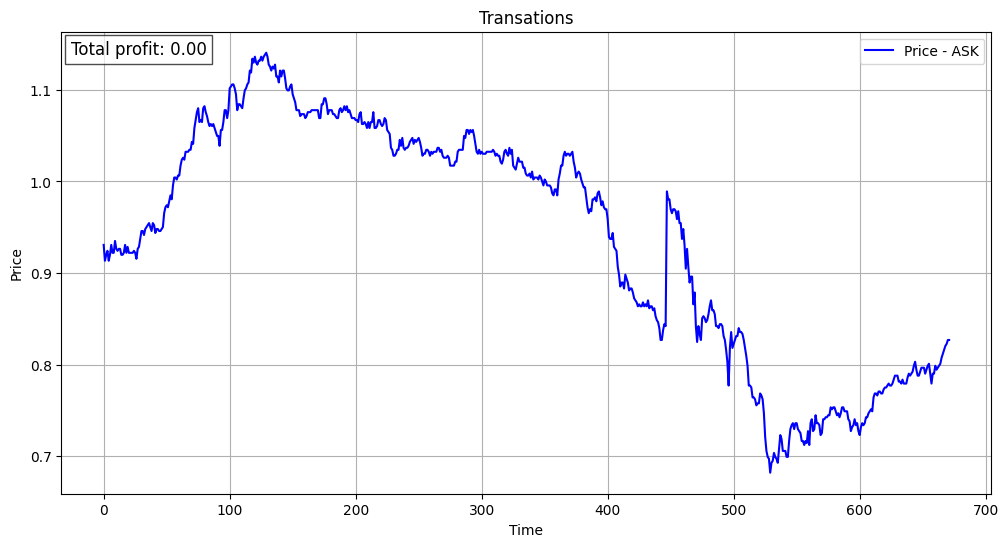

In [ ]:
total_profit, trainsations = lstm_eval_strategy(lstm_ts_val, predictions_val)
plot_buy_points_with_profits(lstm_ts_val, trainsations, total_profit)

In [ ]:
lstm_model_final = LSTM(input_size=2, hidden_size=params_lstm["hidden_size"], dense_layers=[params_lstm["hidden_size"], 10,2], num_layers=1)
optimizer = torch.optim.Adam(lstm_model_final.parameters(), lr=params_lstm["lr"], weight_decay=params_lstm["weight_decay"])
lstm_model_final, _ = train_lstm(lstm_model, trainloader_final, testloader_final, optimizer, epochs=100)

Epoch 1/100
  Train MSE: 0.074557
  Val MSE:   0.049987
Epoch 11/100
  Train MSE: 0.074496
  Val MSE:   0.049987
Epoch 21/100
  Train MSE: 0.074346
  Val MSE:   0.049987
Early stopping at epoch 26


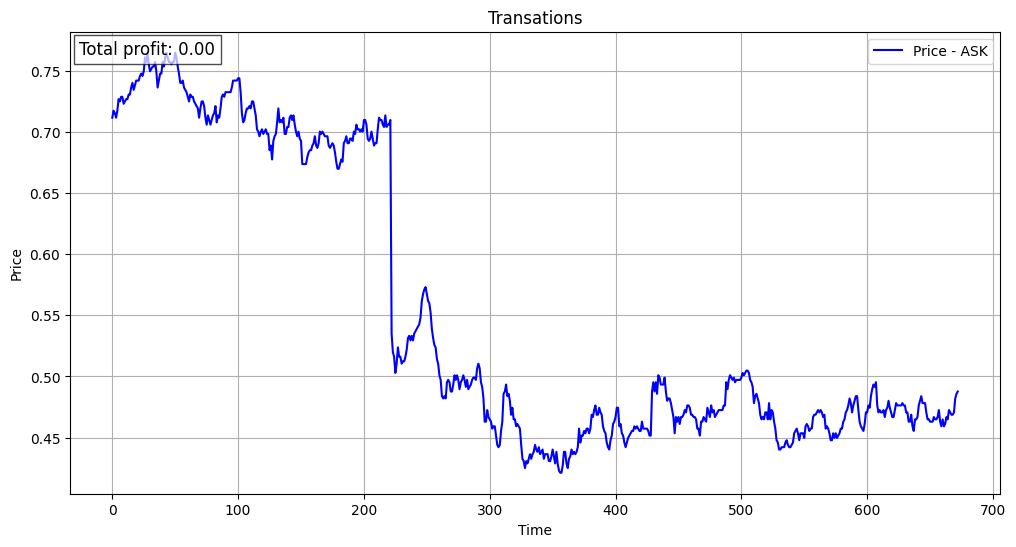

In [ ]:
predictions_final, lstm_ts_final = generate_results_deterministic(test_ts_scaled_final, lstm_model_final, true_to_predict=True, seq_len=SEQ_LEN)
total_profit_final, trainsations_final = lstm_eval_strategy(lstm_ts_final, predictions_final)
plot_buy_points_with_profits(lstm_ts_final, trainsations_final, total_profit_final)

In [ ]:
predictions_final.shape

(673, 2)

In [ ]:
lstm_ts_final

array([[0.70967742, 0.71157495],
       [0.71726755, 0.71726755],
       [0.71537002, 0.71537002],
       ...,
       [0.48387097, 0.48197343],
       [0.4857685 , 0.4857685 ],
       [0.48956357, 0.48766603]])

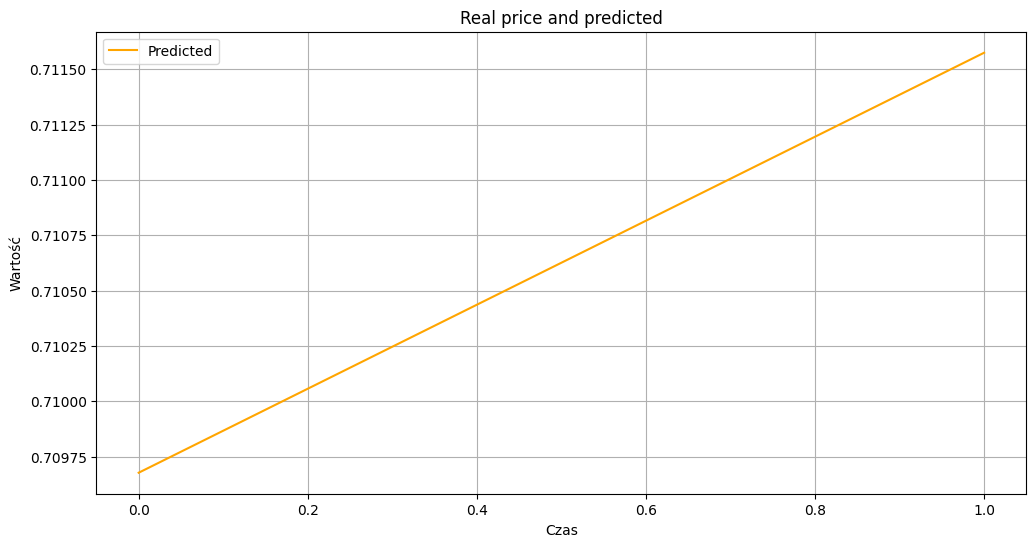

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(lstm_ts_final[0], label='Predicted', color='orange')
plt.title('Real price and predicted')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.legend()
plt.grid(True)
plt.show()
